In [849]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from jj import frequency_array, frequency_array_fit2, frequency_array_fit3, resonance_model, resonance_model2, frequency_array_fit4
from scipy.optimize import curve_fit, differential_evolution

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Dependence of the resonance to the $C_{in}$

c:\Users\jc269556\Documents\Fermionic-bosonic-qubit\jj.py:60: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals)/2/np.pi


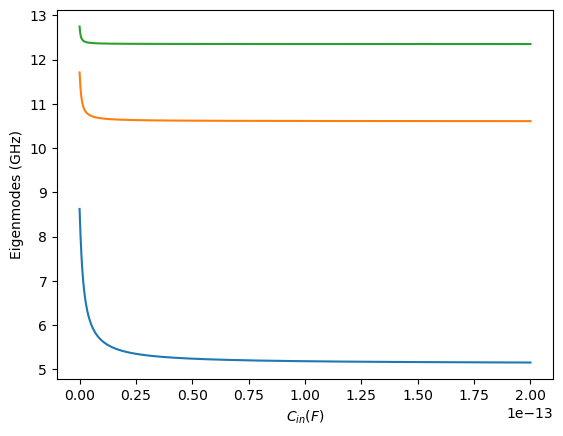

In [2]:
# cin_list = np.geomspace(1e-17,0.2e-12,20)
cin_list = np.linspace(1e-17,0.2e-12,1000)
reso_array = np.zeros((len(cin_list),7))
for i,cin in enumerate(cin_list):
    reso_array[i] = frequency_array(150,32.4e-15,4.1e-9,32.4e-15*0.0007,cin,0)[1:8]*1e-9

plt.close('all')
fig,ax = plt.subplots(1,1)
ax.plot(cin_list,reso_array[:,:3])
ax.set_xscale('linear')
ax.set_xlabel(r'$C_{in} (F)$')
ax.set_ylabel(r'Eigenmodes (GHz)')
plt.show()

Fitting the HFSS simulation with the model

In [150]:
# filename = 'Eigen Modes Table 1.csv'
filename = 'Eigen Modes Table 2.csv'
data = pd.read_csv(filename)
data

,capacitor_length [um],re(Mode(1)) [],re(Mode(2)) [],re(Mode(3)) [],re(Mode(4)) [],re(Mode(5)) [],re(Mode(6)) []
0,1.000000,1.044694e+10,1.258601e+10,1.316587e+10,1.340210e+10,1.352236e+10,1.359175e+10
1,4.222222,1.026935e+10,1.252060e+10,1.313273e+10,1.338407e+10,1.351025e+10,1.358417e+10
2,7.444444,1.004577e+10,1.243799e+10,1.309964e+10,1.337051e+10,1.350392e+10,1.358172e+10
3,10.666667,9.912711e+09,1.240402e+10,1.309076e+10,1.336664e+10,1.350066e+10,1.357885e+10
4,13.888889,9.723812e+09,1.236162e+10,1.307874e+10,1.336138e+10,1.349721e+10,1.349939e+10
5,17.111111,9.631230e+09,1.235008e+10,1.307844e+10,1.336371e+10,1.350170e+10,1.358067e+10
6,20.333333,9.464955e+09,1.230777e+10,1.306330e+10,1.335421e+10,1.349703e+10,1.357712e+10
7,23.555556,9.378780e+09,1.230273e+10,1.306622e+10,1.335791e+10,1.349950e+10,1.357988e+10
8,26.777778,9.294765e+09,1.228102e+10,1.305949e+10,1.335547e+10,1.349836e+10,1.357919e+10
9,30.000000,9.199440e+09,1.227049e+10,1.305619e+10,1.335419e+10,1.349801e+10,1.357986e+10


In [166]:
row = 0
resonancias_experimentales = data.iloc[row,1:].values

In [152]:
def objective_function(params):
    model_vals = frequency_array_fit3(params)
    return np.sum((model_vals - resonancias_experimentales)**2)

param_ranges = [(1e-20, 1e-15), # Rango para Cg
                (1e-20, 1e-14)] # Rango para Cin

result = differential_evolution(objective_function, param_ranges)

optimal_params = result.x
print("Optimal Parameters:", optimal_params)

Cg_ajustado, Cin_ajustado = optimal_params

c:\Users\jc269556\Documents\Fermionic-bosonic-qubit\jj.py:72: RuntimeWarning: invalid value encountered in sqrt


Optimal Parameters: [1.12507396e-17 1.65247910e-20]


In [168]:
# Ajuste de curva 
xdata = np.arange(1,len(resonancias_experimentales)+1)
parametros_iniciales = [0.0003]
# limites = ([0, 0, 0], [np.inf, np.inf, np.inf])
ajuste, covarianza = curve_fit(resonance_model2, xdata, resonancias_experimentales, p0=parametros_iniciales)

# Los parámetros ajustados están en 'ajuste'
ratio_ajustado = ajuste

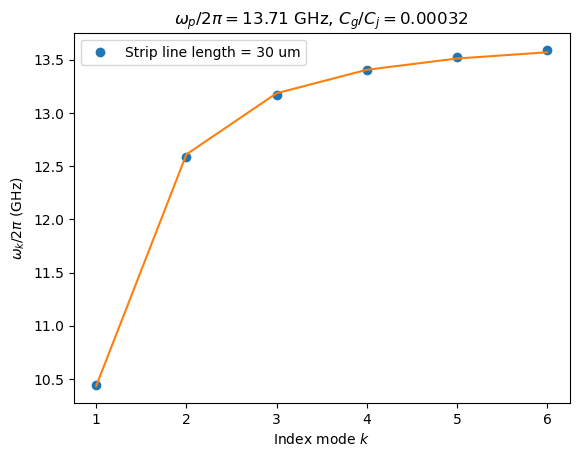

In [144]:
fig,ax = plt.subplots(1,1)
ax.plot(xdata,resonancias_experimentales*1e-9,'o', label = 'Strip line length = 30 um')
# ax.plot(xdata,frequency_array_fit(xdata,Cjj_ajustado, Cg_ajustado, Cin_ajustado)*1e-9)
ax.plot(xdata,resonance_model(xdata,fp_ajustado, ratio_ajustado)*1e-9)
# ax.set_title(rf'$C_j = {round(Cjj_ajustado*1e15,1)}$ fF, $C_g/C_j = {round(Cg_ajustado/Cjj_ajustado,5)}$, $C_{{in}} = {round(Cin_ajustado*1e15,3)}$ fF')
ax.set_title(rf'$\omega_p/2\pi = {round(fp_ajustado*1e-9,2)}$ GHz, $C_g/C_j = {round(ratio_ajustado,5)}$')
ax.legend()
ax.set_ylabel(r'$\omega_k/2\pi$ (GHz)')
ax.set_xlabel(r'Index mode $k$')
plt.show()

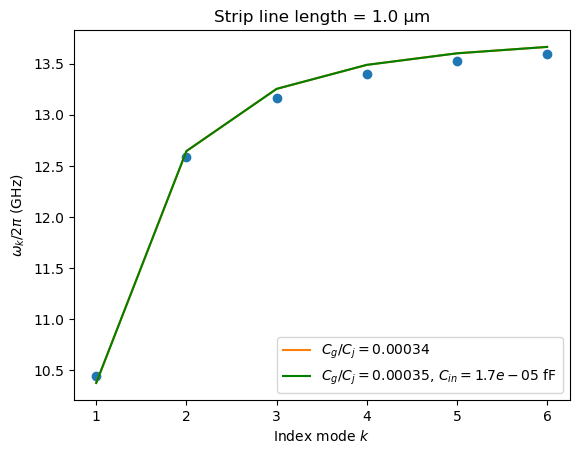

In [182]:
fig,ax = plt.subplots(1,1)
ax.plot(xdata,resonancias_experimentales*1e-9,'o')
ax.plot(xdata,resonance_model2(xdata, ratio_ajustado)*1e-9, label = rf'$C_g/C_j = {round(ratio_ajustado[0],5)}$')
ax.plot(xdata,frequency_array_fit3(optimal_params)*1e-9, label = rf'$C_g/C_j = {round(Cg_ajustado/32.4e-15,5)}$, $C_{{in}} = {round(Cin_ajustado*1e15,6)}$ fF', color='green')
# ax.set_title(rf'$C_j = {round(Cjj_ajustado*1e15,1)}$ fF, $C_g/C_j = {round(Cg_ajustado/Cjj_ajustado,5)}$, $C_{{in}} = {round(Cin_ajustado*1e15,3)}$ fF')
ax.set_title(f'Strip line length = {data.iloc[row,0]} µm')
ax.set_ylabel(r'$\omega_k/2\pi$ (GHz)')
ax.set_xlabel(r'Index mode $k$')
ax.legend()
plt.show()

Comparing what will happen by changing the relative permittivity

In [105]:
filename1 = 'Eigen Modes Table 2.csv'
filename2 = 'Eigen Modes Table 3.csv'
data1 = pd.read_csv(filename1)
data2 = pd.read_csv(filename2)

In [124]:
resonancias_experimentales = data2.iloc[-1,1:].values
def objective_function(params):
    model_vals = frequency_array_fit2(params)
    return np.sum((model_vals - resonancias_experimentales)**2)

param_ranges = [(1e-16, 1e-13), # Rango para Cjj
                (1e-20, 1e-15), # Rango para Cg
                (1e-20, 1e-14)] # Rango para Cin

result = differential_evolution(objective_function, param_ranges)

optimal_params = result.x
print("Optimal Parameters:", optimal_params)

Cjj_ajustado, Cg_ajustado, Cin_ajustado = optimal_params
fp_ajustado_with_cin = 1/2/np.pi/np.sqrt(4.1e-9*Cjj_ajustado)

Optimal Parameters: [3.28281602e-14 9.43416198e-18 6.45200327e-16]


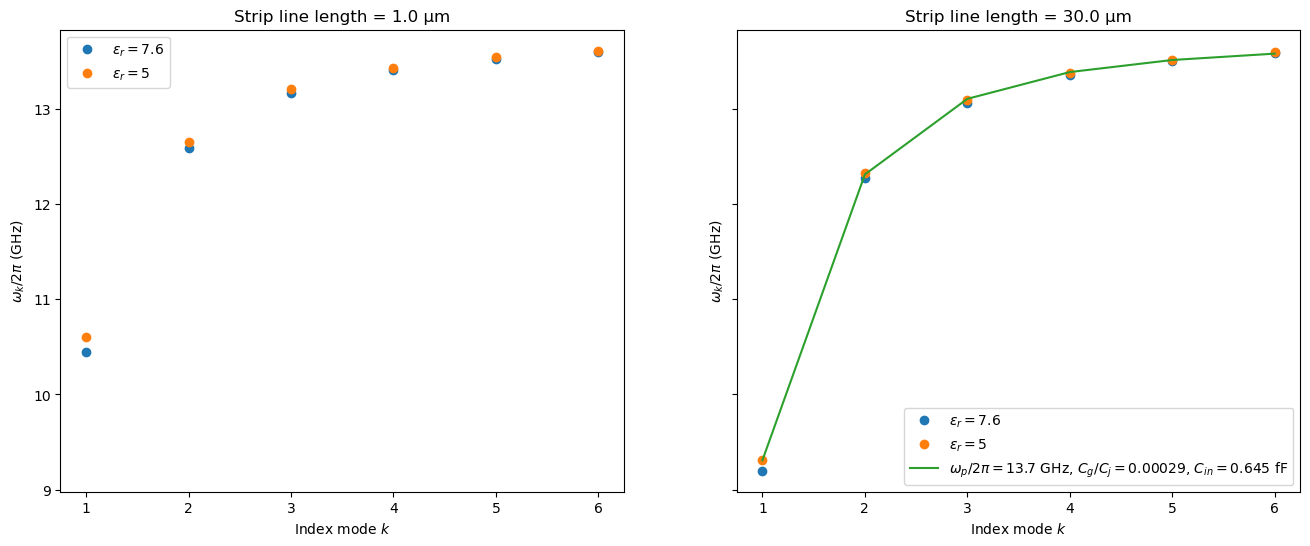

In [129]:
fig,ax = plt.subplots(1,2,figsize = (16,6), sharey=True)
ax[0].plot(xdata,data1.iloc[0,1:].values*1e-9, 'o', label = r'$\varepsilon_r = 7.6$')
ax[0].plot(xdata,data2.iloc[0,1:].values*1e-9, 'o', label = r'$\varepsilon_r = 5$')
ax[0].set_ylabel(r'$\omega_k/2\pi$ (GHz)')
ax[0].set_xlabel(r'Index mode $k$')
ax[0].set_title(f'Strip line length = {data.iloc[0,0]} µm')
ax[0].legend()
ax[1].plot(xdata,data1.iloc[-1,1:].values*1e-9, 'o', label = r'$\varepsilon_r = 7.6$')
ax[1].plot(xdata,data2.iloc[-1,1:].values*1e-9, 'o', label = r'$\varepsilon_r = 5$')
ax[1].plot(xdata,frequency_array_fit2(optimal_params)*1e-9, label = rf'$\omega_p/2\pi = {round(fp_ajustado_with_cin*1e-9,1)}$ GHz, $C_g/C_j = {round(Cg_ajustado/Cjj_ajustado,5)}$, $C_{{in}} = {round(Cin_ajustado*1e15,3)}$ fF')

ax[1].set_ylabel(r'$\omega_k/2\pi$ (GHz)')
ax[1].set_xlabel(r'Index mode $k$')
ax[1].set_title(f'Strip line length = {data.iloc[-1,0]} µm')
ax[1].legend()
plt.show()

Putting only the JJA on top the membrane

In [201]:
data = pd.read_csv('eigen.csv')
data

,capacitor_length [um],re(Mode(1)) [],re(Mode(2)) [],re(Mode(3)) [],re(Mode(4)) [],re(Mode(5)) [],re(Mode(6)) []
0,1,1.069461e+10,1.266265e+10,1.320272e+10,1.342485e+10,1.353862e+10,1.360535e+10


In [203]:
# Ajuste de curva 
xdata = np.arange(1,len(resonancias_experimentales)+1)
parametros_iniciales = [0.0002]
# limites = ([0, 0, 0], [np.inf, np.inf, np.inf])
ajuste, covarianza = curve_fit(resonance_model2, xdata, resonancias_experimentales, p0=parametros_iniciales)

# Los parámetros ajustados están en 'ajuste'
ratio_ajustado = ajuste

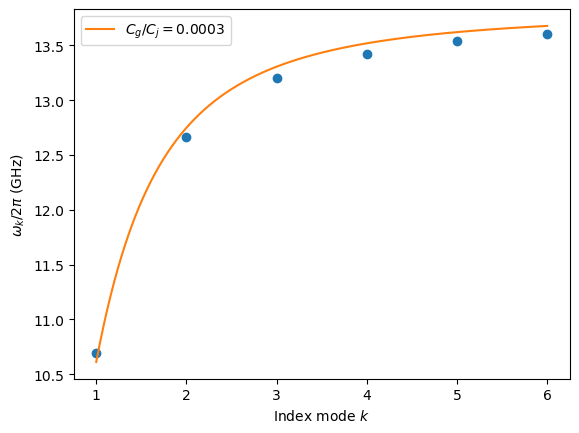

In [205]:
fig,ax = plt.subplots(1,1)
ax.plot(xdata,resonancias_experimentales*1e-9,'o')
x_data_2 = np.linspace(np.min(xdata),np.max(xdata),1000)
ax.plot(x_data_2,resonance_model2(x_data_2, ratio_ajustado)*1e-9, label = rf'$C_g/C_j = {round(ratio_ajustado[0],5)}$')
# ax.set_title(f'Strip line length = {data.iloc[row,0]} µm')
ax.set_ylabel(r'$\omega_k/2\pi$ (GHz)')
ax.set_xlabel(r'Index mode $k$')
ax.legend()
plt.show()

JJA on silicon

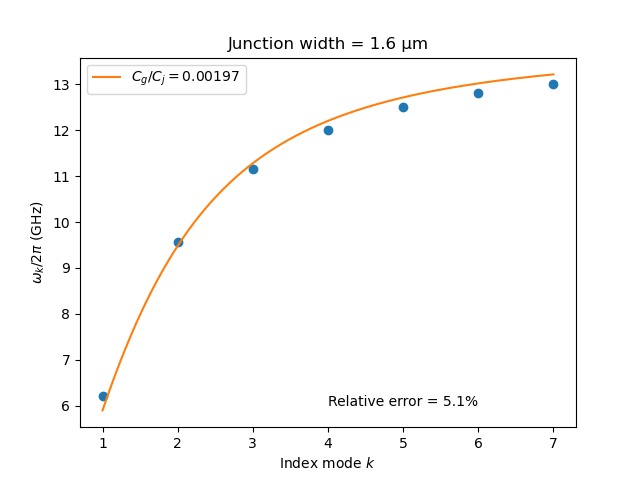

In [581]:
data = pd.read_csv('eigen_silicon.csv')
resonancias_experimentales = data.iloc[0,1:].values

# Ajuste de curva 
xdata = np.arange(1,len(resonancias_experimentales)+1)
parametros_iniciales = [0.002]
# limites = ([0, 0, 0], [np.inf, np.inf, np.inf])
ajuste, covarianza = curve_fit(resonance_model2, xdata, resonancias_experimentales, p0=parametros_iniciales)

# Los parámetros ajustados están en 'ajuste'
ratio_ajustado = ajuste

fig,ax = plt.subplots(1,1)
ax.plot(xdata,resonancias_experimentales*1e-9,'o')
x_data_2 = np.linspace(np.min(xdata),np.max(xdata),1000)
ax.plot(x_data_2,resonance_model2(x_data_2, ratio_ajustado)*1e-9, label = rf'$C_g/C_j = {round(ratio_ajustado[0],5)}$')
ax.set_title('Junction width = 1.6 µm')
ax.text(x=4, y = 6,s=f'Relative error = {round(np.sqrt(covarianza[0,0])/ajuste[0] *100,2)}%')
ax.set_ylabel(r'$\omega_k/2\pi$ (GHz)')
ax.set_xlabel(r'Index mode $k$')
ax.legend()
plt.show()

.1 Freeing the plasma frequency:

In [833]:
data = pd.read_csv('eigen_silicon.csv')
data

,capacitor_length [um],re(Mode(1)) [],re(Mode(2)) [],re(Mode(3)) [],re(Mode(4)) [],re(Mode(5)) [],re(Mode(6)) [],re(Mode(7)) []
0,1,6.219574e+09,9.557357e+09,1.116352e+10,1.200754e+10,1.249834e+10,1.280460e+10,1.300958e+10


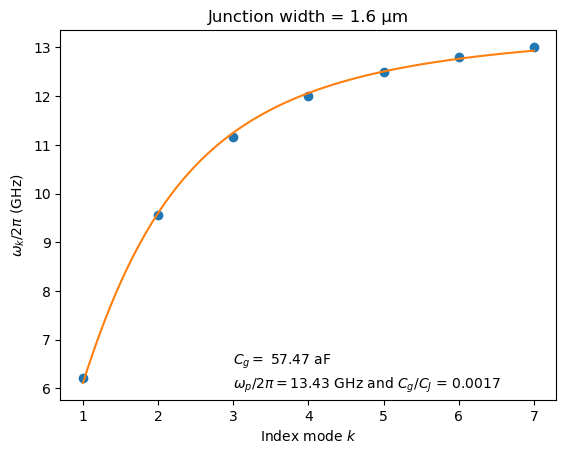

In [644]:
data = pd.read_csv('eigen_silicon.csv')
resonancias_experimentales = data.iloc[0,1:].values

# Ajuste de curva 
xdata = np.arange(1,len(resonancias_experimentales)+1)
parametros_iniciales = [13.8e9,0.002]
# limites = ([0, 0, 0], [np.inf, np.inf, np.inf])
ajuste, covarianza = curve_fit(resonance_model, xdata, resonancias_experimentales, p0=parametros_iniciales)

# Los parámetros ajustados están en 'ajuste'
fp_fit,ratio_ajustado = ajuste
Cg_fit = ratio_ajustado/4.1e-9/(2*np.pi*fp_fit)**2

fig,ax = plt.subplots(1,1)
ax.plot(xdata,resonancias_experimentales*1e-9,'o')
x_data_2 = np.linspace(np.min(xdata),np.max(xdata),100)
# ax.plot(x_data_2,resonance_model(x_data_2, fp_fit,ratio_ajustado)*1e-9, label = rf'$C_g/C_j = {round(ratio_ajustado[0],5)}$')
ax.plot(x_data_2,resonance_model(x_data_2, fp_fit,ratio_ajustado)*1e-9)
ax.set_title('Junction width = 1.6 µm')
ax.text(x=3, y = 6,s=rf'$\omega_p/2\pi = {round(fp_fit*1e-9,2)}$ GHz and $C_g/C_J$ = {round(ratio_ajustado,4)}')
ax.text(x=3, y = 6.5,s=rf'$C_g =$ {round(Cg_fit*1e18,2)} aF')
ax.set_ylabel(r'$\omega_k/2\pi$ (GHz)')
ax.set_xlabel(r'Index mode $k$')
# ax.legend()
plt.show()

In [645]:
Lj = 4.1e-9
Cj = 1/(2*np.pi*fp_fit)**2 / Lj
Cj*1e15

34.26247697174231

JJA on silicon with width = 0.8 µm

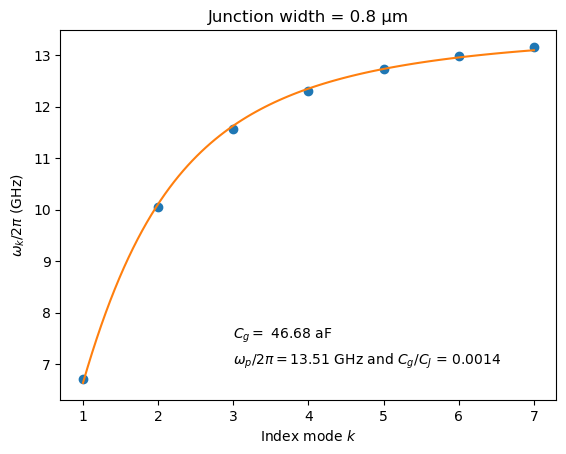

In [641]:
data = pd.read_csv('for_cg.csv')
resonancias_experimentales = data.iloc[0,2:].values

# Ajuste de curva 
xdata = np.arange(1,len(resonancias_experimentales)+1)
parametros_iniciales = [13.8e9,0.002]
# limites = ([0, 0, 0], [np.inf, np.inf, np.inf])
ajuste, covarianza = curve_fit(resonance_model, xdata, resonancias_experimentales, p0=parametros_iniciales)

# Los parámetros ajustados están en 'ajuste'
fp_fit,ratio_ajustado = ajuste
Cg_fit = ratio_ajustado/4.1e-9/(2*np.pi*fp_fit)**2

fig,ax = plt.subplots(1,1)
ax.plot(xdata,resonancias_experimentales*1e-9,'o')
x_data_2 = np.linspace(np.min(xdata),np.max(xdata),100)
# ax.plot(x_data_2,resonance_model(x_data_2, fp_fit,ratio_ajustado)*1e-9, label = rf'$C_g/C_j = {round(ratio_ajustado[0],5)}$')
ax.plot(x_data_2,resonance_model(x_data_2, fp_fit,ratio_ajustado)*1e-9)
ax.set_title('Junction width = 0.8 µm')
ax.text(x=3, y = 7,s=rf'$\omega_p/2\pi = {round(fp_fit*1e-9,2)}$ GHz and $C_g/C_J$ = {round(ratio_ajustado,4)}')
ax.text(x=3, y = 7.5,s=rf'$C_g =$ {round(Cg_fit*1e18,2)} aF')
ax.set_ylabel(r'$\omega_k/2\pi$ (GHz)')
ax.set_xlabel(r'Index mode $k$')
# ax.legend()
plt.show()

In [640]:
np.abs(46.91-57.47)/(46.91+57.47)*2

0.20233761256945781

JJA on silicon with width = 0.01 µm

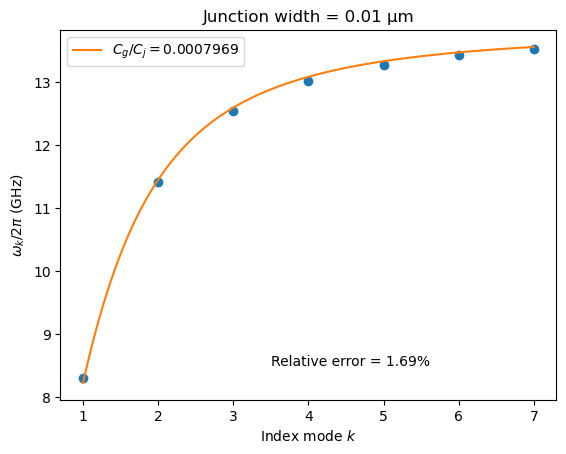

In [596]:
data = pd.read_csv('eigen_silicon_long.csv')
resonancias_experimentales = data.iloc[0,1:].values

# Ajuste de curva 
xdata = np.arange(1,len(resonancias_experimentales)+1)
parametros_iniciales = [0.0003]
# limites = ([0, 0, 0], [np.inf, np.inf, np.inf])
ajuste, covarianza = curve_fit(resonance_model2, xdata, resonancias_experimentales, p0=parametros_iniciales)

# Los parámetros ajustados están en 'ajuste'
ratio_ajustado = ajuste

fig,ax = plt.subplots(1,1)
ax.plot(xdata,resonancias_experimentales*1e-9,'o')
x_data_2 = np.linspace(np.min(xdata),np.max(xdata),1000)
ax.plot(x_data_2,resonance_model2(x_data_2, ratio_ajustado)*1e-9, label = rf'$C_g/C_j = {round(ratio_ajustado[0],7)}$')
ax.set_title('Junction width = 0.01 µm')
ax.text(x=3.5, y = 8.5,s=f'Relative error = {round(np.sqrt(covarianza[0,0])/ajuste[0] *100,2)}%')
ax.set_ylabel(r'$\omega_k/2\pi$ (GHz)')
ax.set_xlabel(r'Index mode $k$')
ax.legend()
plt.show()

.1 By freeing the plasma frequency:

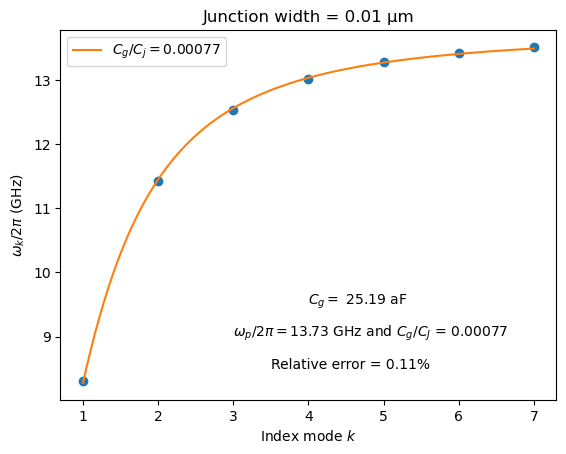

In [616]:
data = pd.read_csv('eigen_silicon_long.csv')
resonancias_experimentales = data.iloc[0,1:].values

# Ajuste de curva 
xdata = np.arange(1,len(resonancias_experimentales)+1)
parametros_iniciales = [13.8e9,0.0003]
# limites = ([0, 0, 0], [np.inf, np.inf, np.inf])
ajuste, covarianza = curve_fit(resonance_model, xdata, resonancias_experimentales, p0=parametros_iniciales)

# Los parámetros ajustados están en 'ajuste'
fp_fit,ratio_ajustado = ajuste
Cg_fit = ratio_ajustado/4.1e-9/(2*np.pi*fp_fit)**2

fig,ax = plt.subplots(1,1)
ax.plot(xdata,resonancias_experimentales*1e-9,'o')
x_data_2 = np.linspace(np.min(xdata),np.max(xdata),1000)
ax.plot(x_data_2,resonance_model(x_data_2, fp_fit,ratio_ajustado)*1e-9, label = rf'$C_g/C_j = {round(ratio_ajustado,5)}$')
ax.set_title('Junction width = 0.01 µm')
ax.text(x=3.5, y = 8.5,s=f'Relative error = {round(np.sqrt(covarianza[0,0])/ajuste[0] *100,2)}%')
ax.text(x=3, y = 9,s=rf'$\omega_p/2\pi = {round(fp_fit*1e-9,2)}$ GHz and $C_g/C_J$ = {round(ratio_ajustado,5)}')
ax.text(x=4, y = 9.5,s=rf'$C_g =$ {round(Cg_fit*1e18,2)} aF')
ax.set_ylabel(r'$\omega_k/2\pi$ (GHz)')
ax.set_xlabel(r'Index mode $k$')
ax.legend()
plt.show()

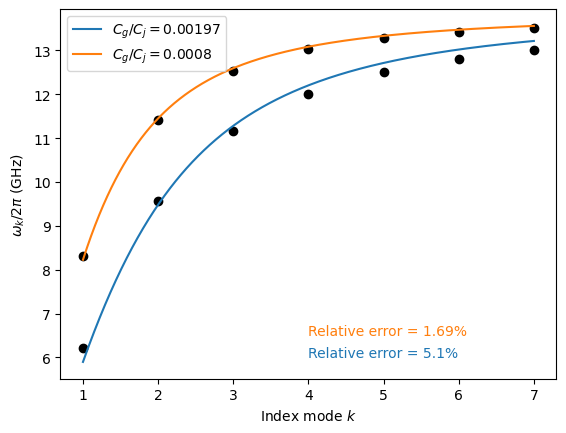

In [404]:
data = pd.read_csv('eigen_silicon.csv')
data_l = pd.read_csv('eigen_silicon_long.csv')
resonancias_experimentales = data.iloc[0,1:].values
resonancias_experimentales_l = data_l.iloc[0,1:].values

# Ajuste de curva 
xdata = np.arange(1,len(resonancias_experimentales)+1)
xdata_l = np.arange(1,len(resonancias_experimentales_l)+1)
parametros_iniciales = [0.0003]
# limites = ([0, 0, 0], [np.inf, np.inf, np.inf])
ajuste, covarianza = curve_fit(resonance_model2, xdata, resonancias_experimentales, p0=parametros_iniciales)
ajuste_l, covarianza_l = curve_fit(resonance_model2, xdata_l, resonancias_experimentales_l, p0=parametros_iniciales)

# Los parámetros ajustados están en 'ajuste'
ratio_ajustado = ajuste
ratio_ajustado_l = ajuste_l

fig,ax = plt.subplots(1,1)
ax.plot(xdata,resonancias_experimentales*1e-9,'o', color='k')
ax.plot(xdata_l,resonancias_experimentales_l*1e-9,'o', color='k')
x_data_2 = np.linspace(np.min(xdata),np.max(xdata),1000)
x_data_2_l = np.linspace(np.min(xdata_l),np.max(xdata_l),1000)
ax.plot(x_data_2,resonance_model2(x_data_2, ratio_ajustado)*1e-9, label = rf'$C_g/C_j = {round(ratio_ajustado[0],5)}$')
ax.plot(x_data_2_l,resonance_model2(x_data_2_l, ratio_ajustado_l)*1e-9, label = rf'$C_g/C_j = {round(ratio_ajustado_l[0],5)}$')
# ax.set_title('Junction width = 0.01 µm')
ax.text(x=4, y = 6,s=f'Relative error = {round(np.sqrt(covarianza[0,0])/ajuste[0] *100,2)}%', color='C0')
ax.text(x=4, y = 6.5,s=f'Relative error = {round(np.sqrt(covarianza_l[0,0])/ajuste_l[0] *100,2)}%', color='C1')
ax.set_ylabel(r'$\omega_k/2\pi$ (GHz)')
ax.set_xlabel(r'Index mode $k$')
ax.legend()
plt.show()

Considering now the JJ in the model as one with a length of 10 nm in the simulation

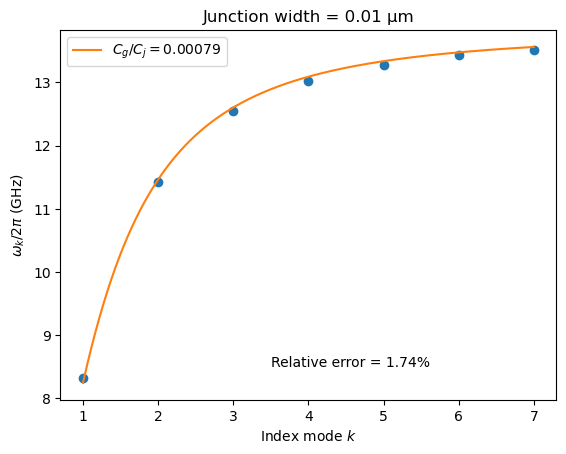

In [406]:
data = pd.read_csv('Eigen_silicon_long_new_jj.csv')
resonancias_experimentales = data.iloc[0,1:].values

# Ajuste de curva 
xdata = np.arange(1,len(resonancias_experimentales)+1)
parametros_iniciales = [0.0003]
# limites = ([0, 0, 0], [np.inf, np.inf, np.inf])
ajuste, covarianza = curve_fit(resonance_model2, xdata, resonancias_experimentales, p0=parametros_iniciales)

# Los parámetros ajustados están en 'ajuste'
ratio_ajustado = ajuste

fig,ax = plt.subplots(1,1)
ax.plot(xdata,resonancias_experimentales*1e-9,'o')
x_data_2 = np.linspace(np.min(xdata),np.max(xdata),1000)
ax.plot(x_data_2,resonance_model2(x_data_2, ratio_ajustado)*1e-9, label = rf'$C_g/C_j = {round(ratio_ajustado[0],5)}$')
ax.set_title('Junction width = 0.01 µm')
ax.text(x=3.5, y = 8.5,s=f'Relative error = {round(np.sqrt(covarianza[0,0])/ajuste[0] *100,2)}%')
ax.set_ylabel(r'$\omega_k/2\pi$ (GHz)')
ax.set_xlabel(r'Index mode $k$')
ax.legend()
plt.show()

JJA with junction width = 1.6 µm and a junction length of 10 nm with a strip perfect conductor of 1.1 µm/2 - 10 nm

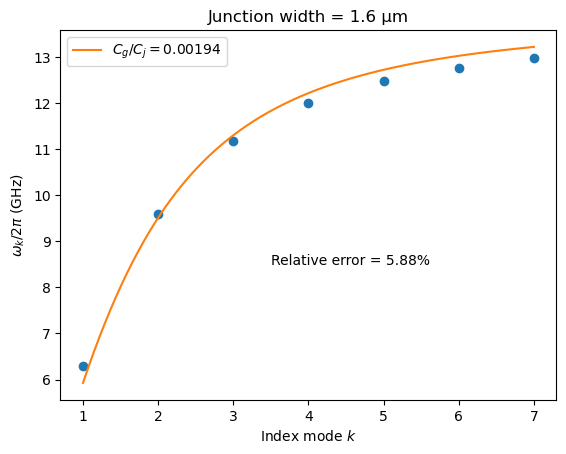

In [407]:
data = pd.read_csv('Eigen_silicon_new_jj.csv')
resonancias_experimentales = data.iloc[0,1:].values

# Ajuste de curva 
xdata = np.arange(1,len(resonancias_experimentales)+1)
parametros_iniciales = [0.0003]
# limites = ([0, 0, 0], [np.inf, np.inf, np.inf])
ajuste, covarianza = curve_fit(resonance_model2, xdata, resonancias_experimentales, p0=parametros_iniciales)

# Los parámetros ajustados están en 'ajuste'
ratio_ajustado = ajuste

fig,ax = plt.subplots(1,1)
ax.plot(xdata,resonancias_experimentales*1e-9,'o')
x_data_2 = np.linspace(np.min(xdata),np.max(xdata),1000)
ax.plot(x_data_2,resonance_model2(x_data_2, ratio_ajustado)*1e-9, label = rf'$C_g/C_j = {round(ratio_ajustado[0],5)}$')
ax.set_title('Junction width = 1.6 µm')
ax.text(x=3.5, y = 8.5,s=f'Relative error = {round(np.sqrt(covarianza[0,0])/ajuste[0] *100,2)}%')
ax.set_ylabel(r'$\omega_k/2\pi$ (GHz)')
ax.set_xlabel(r'Index mode $k$')
ax.legend()
plt.show()

Studying the effect of the aspect ratio at a fixed area

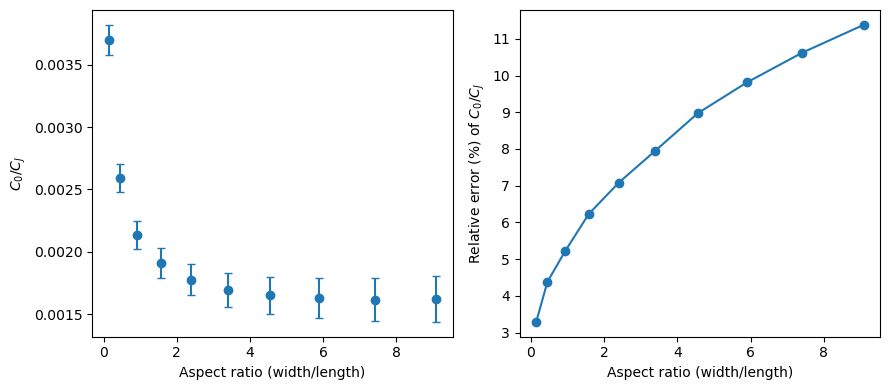

In [532]:
data = pd.read_csv('aspect_ratio2.csv')
resonances_array = np.zeros((len(data),len(data.iloc[0,1:])))
area = 1.6*1.1
aspect_ratio = data.iloc[:,0]**2/area
ajuste = np.zeros(len(data))
covarianza = np.zeros(len(data))
xdata = np.arange(1,len(data.iloc[0,1:])+1)
parametros_iniciales = [0.0003]

for i,width in enumerate(data.iloc[:,0]):
    resonances_array[i] = data.iloc[i,1:]
    ajuste[i], covarianza[i] = curve_fit(resonance_model2, xdata, resonances_array[i], p0=parametros_iniciales)

fig,ax = plt.subplots(1,2,figsize = (9,4))
ax[0].errorbar(aspect_ratio, ajuste, yerr=np.sqrt(covarianza), fmt='o', capsize=3, capthick=1)
ax[0].set_xlabel(r'Aspect ratio (width/length)')
ax[1].set_xlabel(r'Aspect ratio (width/length)')
ax[0].set_ylabel(r'$C_0/C_J$')
ax[1].set_ylabel(r'Relative error (%) of $C_0/C_J$')
ax[1].plot(aspect_ratio,np.sqrt(covarianza)/ajuste*100, 'o-')
plt.tight_layout()
plt.show()

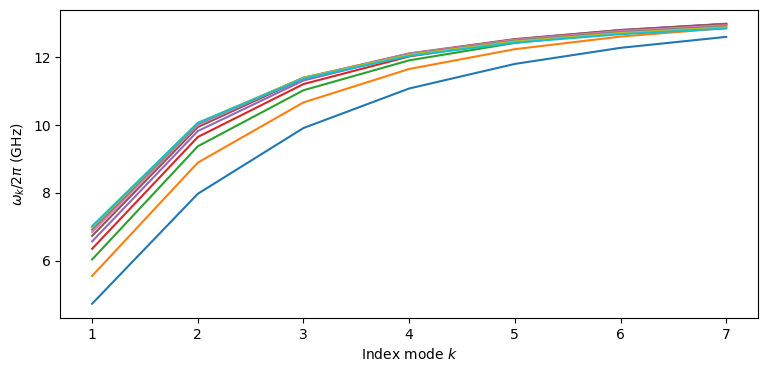

In [533]:
fig,ax = plt.subplots(1,1,figsize = (9,4))
ax.plot(xdata, resonances_array.T*1e-9)
ax.set_xlabel(r'Index mode $k$')
ax.set_ylabel(r'$\omega_k /2\pi$ (GHz)')
plt.show()

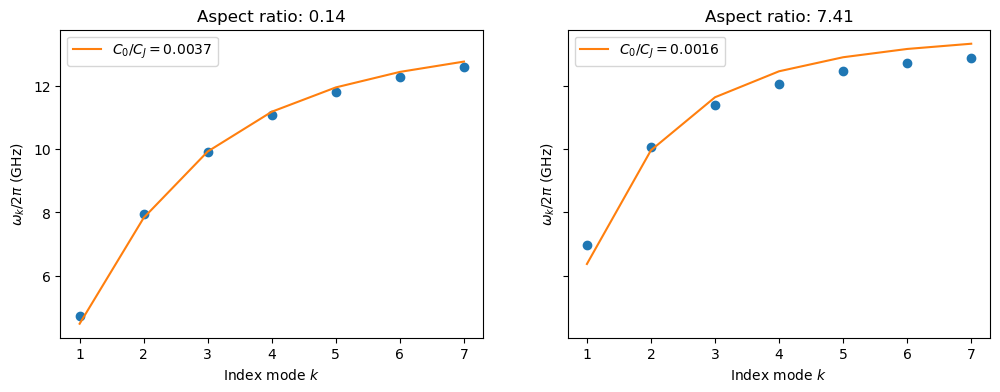

In [534]:
fig,ax = plt.subplots(1,2,figsize = (12,4),sharey=True)
ax[0].plot(xdata, resonances_array[0]*1e-9,'o')
ax[0].plot(xdata, resonance_model2(xdata,ajuste[0])*1e-9, label=rf'$C_0/C_J = {round(ajuste[0],4)}$')
ax[1].plot(xdata, resonances_array[-2]*1e-9,'o')
ax[1].plot(xdata, resonance_model2(xdata,ajuste[-2])*1e-9, label=rf'$C_0/C_J = {round(ajuste[-2],4)}$')
ax[0].set_title(f'Aspect ratio: {round(data.iloc[0,0]**2/area,2)}')
ax[1].set_title(f'Aspect ratio: {round(data.iloc[-2,0]**2/area,2)}')
ax[0].set_xlabel(r'Index mode $k$')
ax[1].set_xlabel(r'Index mode $k$')
ax[0].set_ylabel(r'$\omega_k /2\pi$ (GHz)')
ax[1].set_ylabel(r'$\omega_k /2\pi$ (GHz)')
ax[0].legend()
ax[1].legend()
plt.show()

Leaving free the plasma frequency in the fit

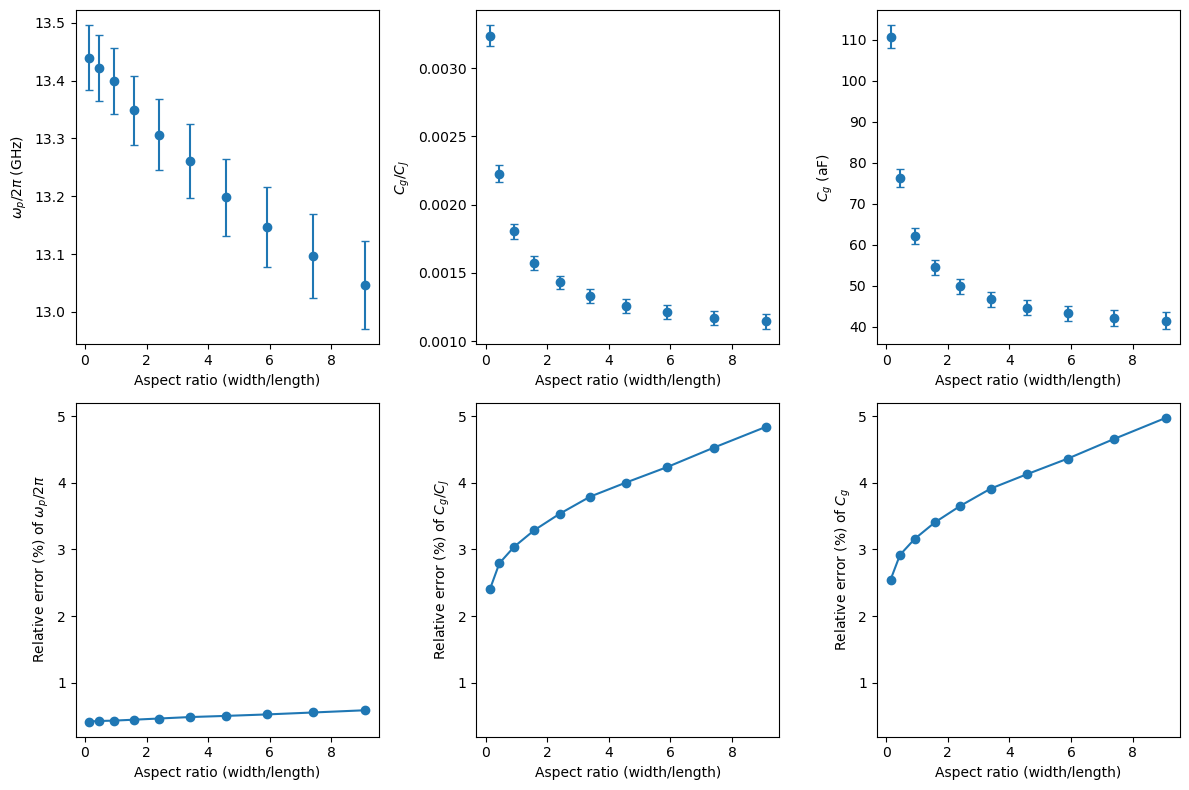

In [758]:
data = pd.read_csv('aspect_ratio2.csv')
resonances_array = np.zeros((len(data),len(data.iloc[0,1:])))
area = 1.6*1.1
aspect_ratio = data.iloc[:,0]**2/area
fp_fit = np.zeros(len(data))
ratio_fit = np.zeros(len(data))
sd_fp = np.zeros(len(data))
sd_ratio = np.zeros(len(data))
xdata = np.arange(1,len(data.iloc[0,1:])+1)
parametros_iniciales = [13.3e9,0.0003]

for i,width in enumerate(data.iloc[:,0]):
    resonances_array[i] = data.iloc[i,1:]
    fit, covarianza = curve_fit(resonance_model, xdata, resonances_array[i], p0=parametros_iniciales)
    fp_fit[i], ratio_fit[i] = fit
    sd_fp[i] = np.sqrt(covarianza[0,0])
    sd_ratio[i] = np.sqrt(covarianza[1,1])

fig,ax = plt.subplots(2,3,figsize = (12,8))
ax[0,0].errorbar(aspect_ratio, fp_fit*1e-9, yerr=sd_fp*1e-9, fmt='o', capsize=3, capthick=1)
ax[0,1].errorbar(aspect_ratio, ratio_fit, yerr=sd_ratio, fmt='o', capsize=3, capthick=1)
ax[0,0].set_xlabel(r'Aspect ratio (width/length)')
ax[0,1].set_xlabel(r'Aspect ratio (width/length)')
ax[0,0].set_ylabel(r'$\omega_p/2\pi$ (GHz)')
ax[0,1].set_ylabel(r'$C_g/C_J$')

ax[1, 1].sharey(ax[1, 0])
ax[1,0].plot(aspect_ratio, sd_fp/fp_fit*100, 'o-')
ax[1,1].plot(aspect_ratio, sd_ratio/ratio_fit*100,'o-')
ax[1,0].set_xlabel(r'Aspect ratio (width/length)')
ax[1,1].set_xlabel(r'Aspect ratio (width/length)')
ax[1,0].set_ylabel(r'Relative error (%) of $\omega_p/2\pi$')
ax[1,1].set_ylabel(r'Relative error (%) of $C_g/C_J$')
Cg = 1/4.1e-9*ratio_fit/(2*np.pi*fp_fit)**2
error_cg = Cg*np.sqrt((1 * sd_ratio/ratio_fit)**2 + (-2 * sd_fp/fp_fit)**2)
ax[0,2].errorbar(aspect_ratio, Cg*1e18, yerr=error_cg*1e18, fmt='o', capsize=3, capthick=1)
ax[0,2].set_xlabel(r'Aspect ratio (width/length)')
ax[0,2].set_ylabel(r'$C_g$ (aF)')

ax[1, 2].sharey(ax[1, 0])
ax[1,2].plot(aspect_ratio,error_cg/Cg*100, 'o-')
ax[1,2].set_xlabel(r'Aspect ratio (width/length)')
ax[1,2].set_ylabel(r'Relative error (%) of $C_g$')
plt.tight_layout()
plt.show()

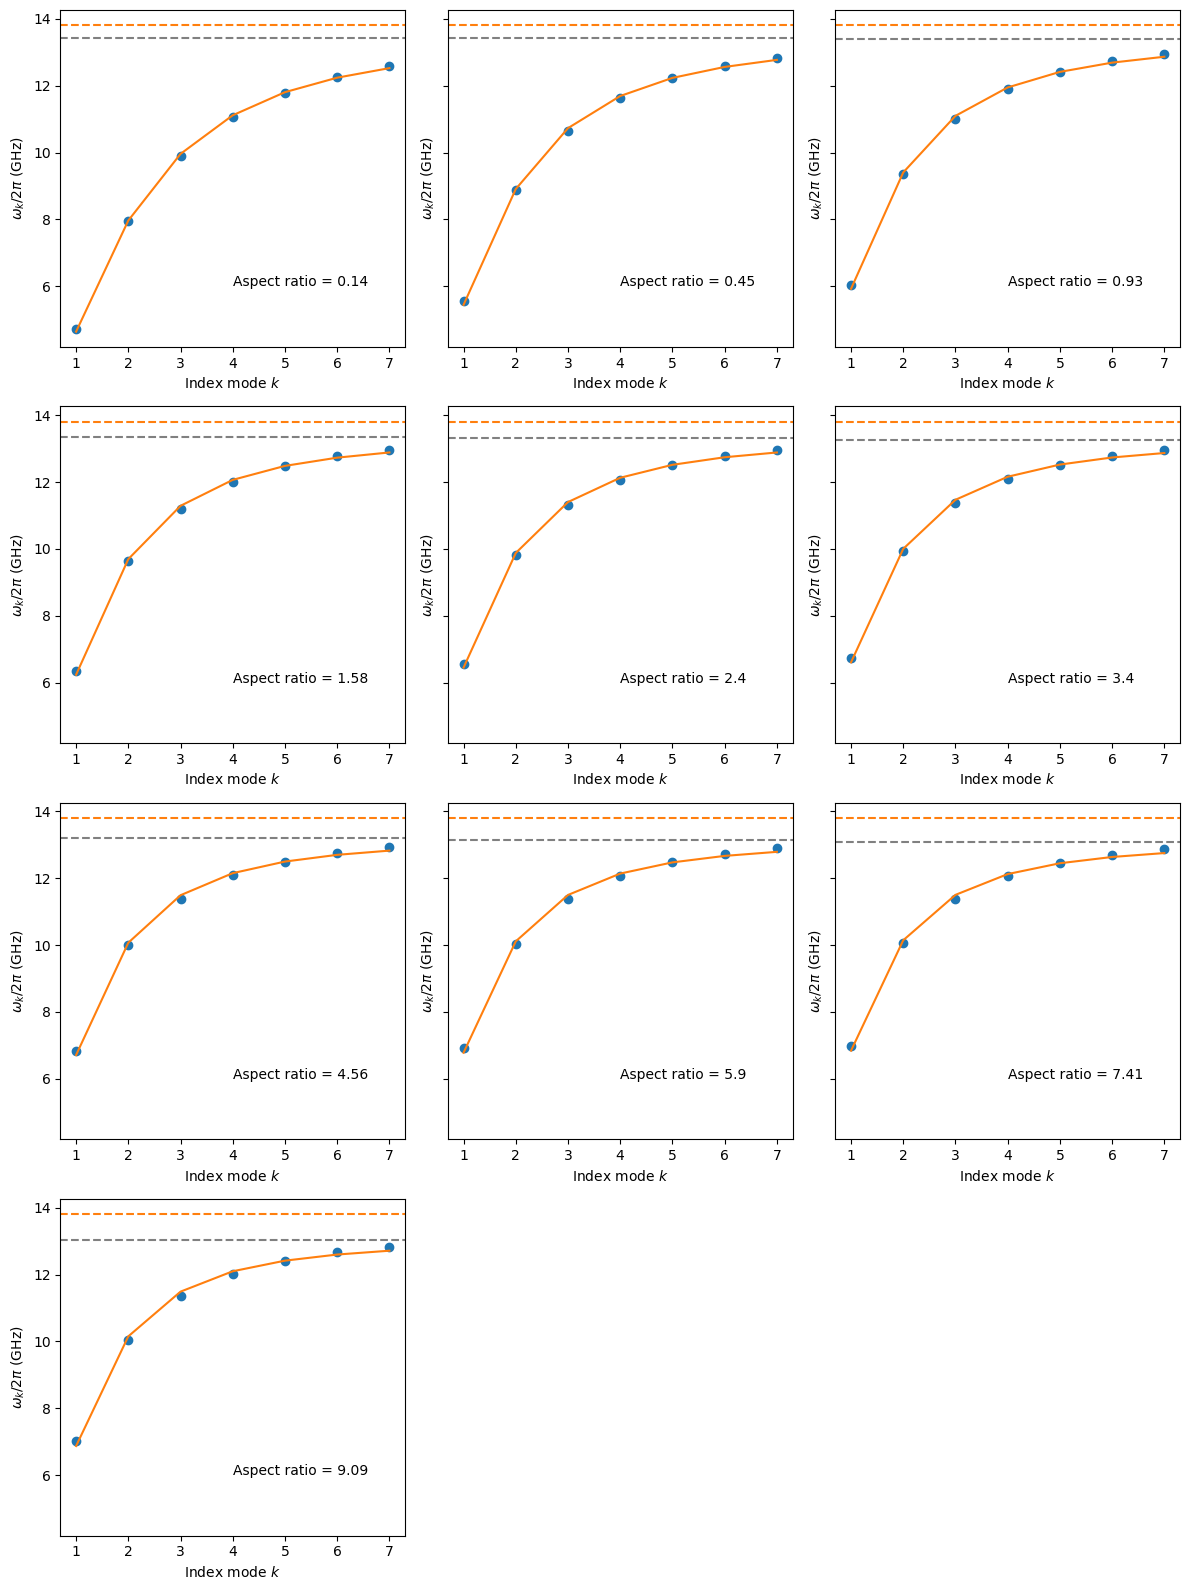

In [671]:
theoretical = 1/2/np.pi/np.sqrt(4.1e-9*32.4e-15)
# Calcular el número de filas necesario para 3 columnas
n_plots = len(resonances_array)
n_rows = int(np.ceil(n_plots / 3))

fig, ax = plt.subplots(n_rows, 3, figsize=(12, 4*n_rows), sharey=True)

for i in range(n_plots):
    row = i // 3
    col = i % 3
    
    ax[row, col].axhline(theoretical * 1e-9, color='C1', linestyle='--')
    ax[row, col].axhline(fp_fit[i] * 1e-9, color='gray', linestyle='--')
    ax[row, col].plot(xdata, resonances_array[i] * 1e-9, 'o')
    ax[row, col].plot(xdata, resonance_model(xdata, fp_fit[i], ratio_fit[i]) * 1e-9)
    ax[row, col].set_xlabel(r'Index mode $k$')
    ax[row, col].set_ylabel(r'$\omega_k/2\pi$ (GHz)')
    ax[row, col].text(x=4, y=6, s=f'Aspect ratio = {round(data.iloc[i, 0]**2 / area, 2)}')

# Para los subplots que no se usan, desactivarlos
for j in range(i+1, n_rows * 3):
    fig.delaxes(ax.flatten()[j])

plt.tight_layout()
plt.show()

Calculating the capacitance based on the Martinis (2014) expression (1): $C_{12} \simeq(\epsilon / \pi) A_1 A_2 / r_{12}^3$

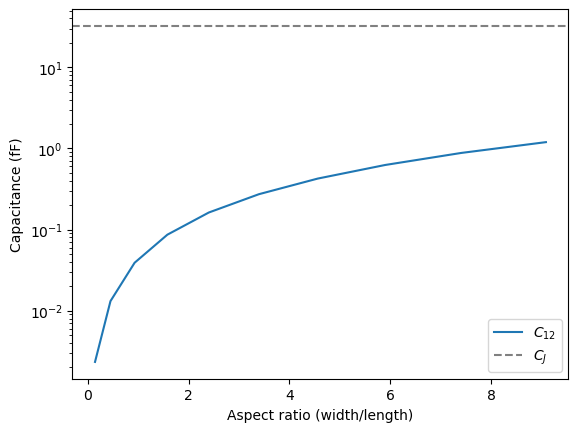

In [ ]:
width_array = data.iloc[:,0]*1e-6
area = 1.6*1.1*1e-12
length = area/width_array
epsilon = 11.68
epsilon_0 = 8.85e-12
c12 = epsilon_0*epsilon/np.pi * area**2/length**3

fig,ax = plt.subplots(1,1)
ax.plot(width_array**2/area,c12*1e15,label=r'$C_{12}$')
ax.axhline(32.4, color='gray',linestyle='--', label=r'$C_J$')
ax.set_yscale('log')
ax.set_xlabel('Aspect ratio (width/length)')
ax.set_ylabel('Capacitance (fF)')
ax.legend()
plt.show()

Using a single JJ to simulate

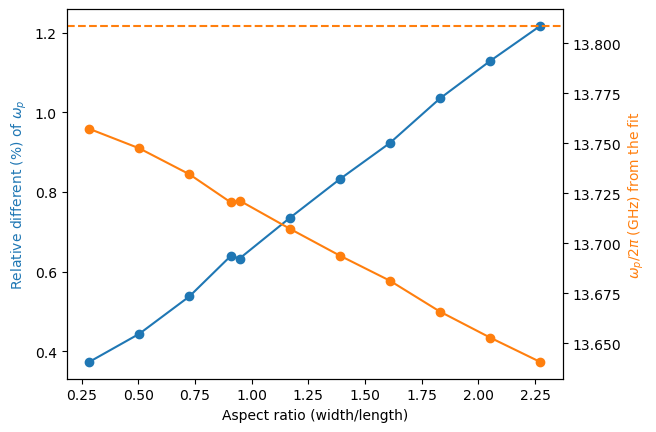

In [468]:
theoretical = 1/2/np.pi/np.sqrt(4.1e-9*32.4e-15)
data = pd.read_csv('single_junction.csv')

fig,ax = plt.subplots(1,1)
ax.plot(data.iloc[:,0]/area,np.abs(data.iloc[:,1]-theoretical)/theoretical*100, 'o-', color='C0')
ax.set_ylabel(r'Relative different (%) of $\omega_p$', color='C0')
ax2 = ax.twinx()
ax2.axhline(theoretical*1e-9, color='C1', linestyle='--')
ax2.plot(data.iloc[:,0]/area,data.iloc[:,1]*1e-9,'o-', color='C1')
ax2.set_ylabel(r'$\omega_p/2\pi$ (GHz) from the fit', color='C1')
ax.set_xlabel('Aspect ratio (width/length)')
plt.show()

U shape

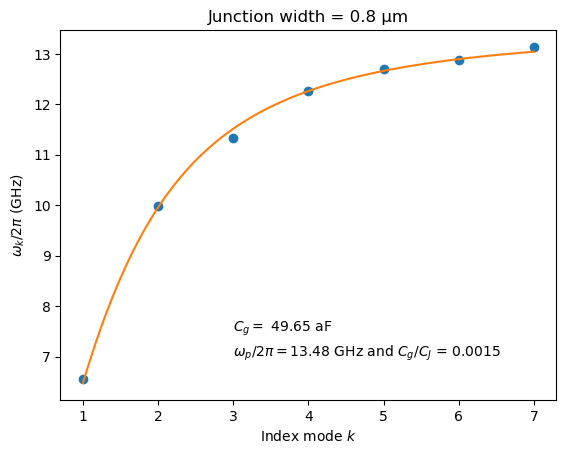

In [686]:
data = pd.read_csv('u_shape.csv')
resonancias_experimentales = data.iloc[0,2:].values

# Ajuste de curva 
xdata = np.arange(1,len(resonancias_experimentales)+1)
parametros_iniciales = [13.8e9,0.002]
# limites = ([0, 0, 0], [np.inf, np.inf, np.inf])
ajuste, covarianza = curve_fit(resonance_model, xdata, resonancias_experimentales, p0=parametros_iniciales)

# Los parámetros ajustados están en 'ajuste'
fp_fit,ratio_ajustado = ajuste
Cg_fit = ratio_ajustado/4.1e-9/(2*np.pi*fp_fit)**2

fig,ax = plt.subplots(1,1)
ax.plot(xdata,resonancias_experimentales*1e-9,'o')
x_data_2 = np.linspace(np.min(xdata),np.max(xdata),100)
# ax.plot(x_data_2,resonance_model(x_data_2, fp_fit,ratio_ajustado)*1e-9, label = rf'$C_g/C_j = {round(ratio_ajustado[0],5)}$')
ax.plot(x_data_2,resonance_model(x_data_2, fp_fit,ratio_ajustado)*1e-9)
ax.set_title(f'Junction width = {data.iloc[0,1]/1000} µm')
ax.text(x=3, y = 7,s=rf'$\omega_p/2\pi = {round(fp_fit*1e-9,2)}$ GHz and $C_g/C_J$ = {round(ratio_ajustado,4)}')
ax.text(x=3, y = 7.5,s=rf'$C_g =$ {round(Cg_fit*1e18,2)} aF')
ax.set_ylabel(r'$\omega_k/2\pi$ (GHz)')
ax.set_xlabel(r'Index mode $k$')
# ax.legend()
plt.show()

Changing the junction width:

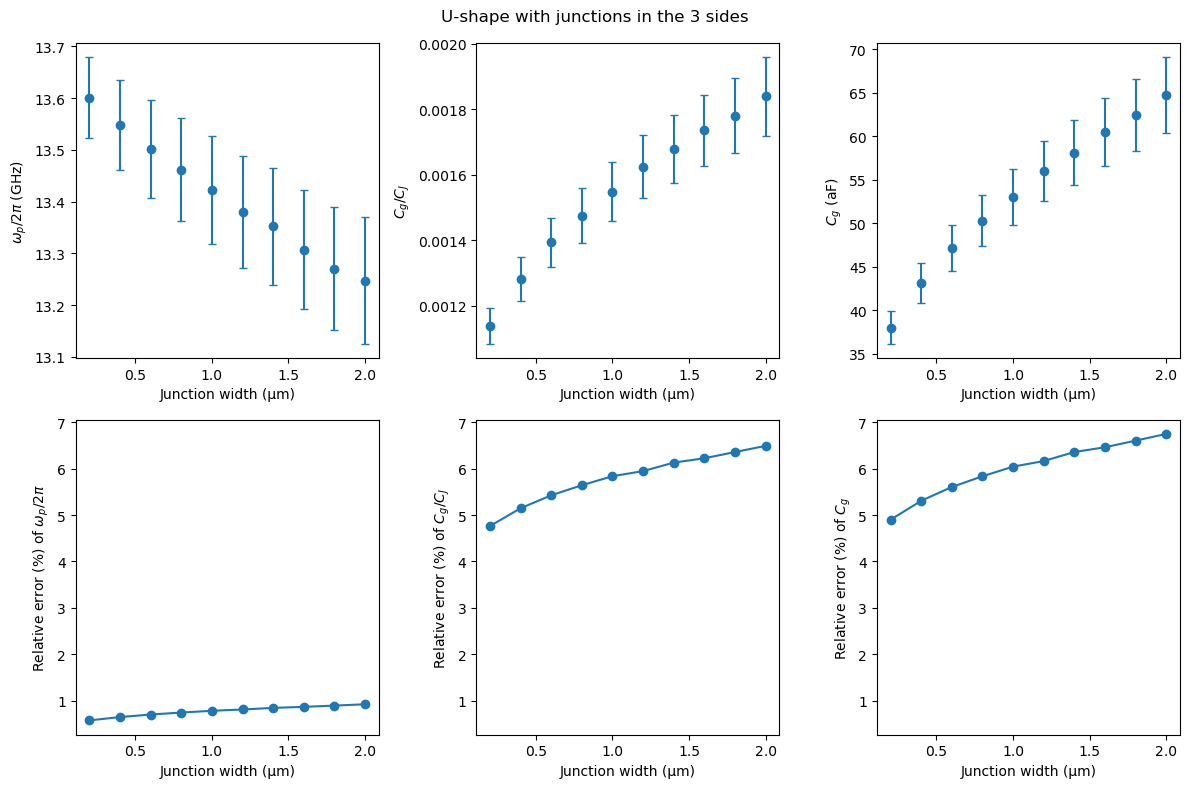

In [808]:
data = pd.read_csv('u_shape_widths.csv')
resonances_array = np.zeros((len(data),len(data.iloc[0,2:])))
fp_fit = np.zeros(len(data))
ratio_fit = np.zeros(len(data))
sd_fp = np.zeros(len(data))
sd_ratio = np.zeros(len(data))
xdata = np.arange(1,len(data.iloc[0,2:])+1)
parametros_iniciales = [13.3e9,0.0003]

widths = data.iloc[:,1]
for i,width in enumerate(widths):
    resonances_array[i] = data.iloc[i,2:]
    fit, covarianza = curve_fit(resonance_model, xdata, resonances_array[i], p0=parametros_iniciales)
    fp_fit[i], ratio_fit[i] = fit
    sd_fp[i] = np.sqrt(covarianza[0,0])
    sd_ratio[i] = np.sqrt(covarianza[1,1])

fig,ax = plt.subplots(2,3,figsize = (12,8))
fig.suptitle('U-shape with junctions in the 3 sides')
ax[0,0].errorbar(widths, fp_fit*1e-9, yerr=sd_fp*1e-9, fmt='o', capsize=3, capthick=1)
ax[0,1].errorbar(widths, ratio_fit, yerr=sd_ratio, fmt='o', capsize=3, capthick=1)
ax[0,0].set_xlabel(r'Junction width (µm)')
ax[0,1].set_xlabel(r'Junction width (µm)')
ax[0,0].set_ylabel(r'$\omega_p/2\pi$ (GHz)')
ax[0,1].set_ylabel(r'$C_g/C_J$')

ax[1, 1].sharey(ax[1, 0])
ax[1,0].plot(widths, sd_fp/fp_fit*100, 'o-')
ax[1,1].plot(widths, sd_ratio/ratio_fit*100,'o-')
ax[1,0].set_xlabel(r'Junction width (µm)')
ax[1,1].set_xlabel(r'Junction width (µm)')
ax[1,0].set_ylabel(r'Relative error (%) of $\omega_p/2\pi$')
ax[1,1].set_ylabel(r'Relative error (%) of $C_g/C_J$')
Cg = 1/4.1e-9*ratio_fit/(2*np.pi*fp_fit)**2
error_cg = Cg*np.sqrt((1 * sd_ratio/ratio_fit)**2 + (-2 * sd_fp/fp_fit)**2)
ax[0,2].errorbar(widths, Cg*1e18, yerr=error_cg*1e18, fmt='o', capsize=3, capthick=1)
ax[0,2].set_xlabel(r'Junction width (µm)')
ax[0,2].set_ylabel(r'$C_g$ (aF)')

ax[1, 2].sharey(ax[1, 0])
ax[1,2].plot(widths,error_cg/Cg*100, 'o-')
ax[1,2].set_xlabel(r'Junction width (µm)')
ax[1,2].set_ylabel(r'Relative error (%) of $C_g$')
plt.tight_layout()
plt.show()

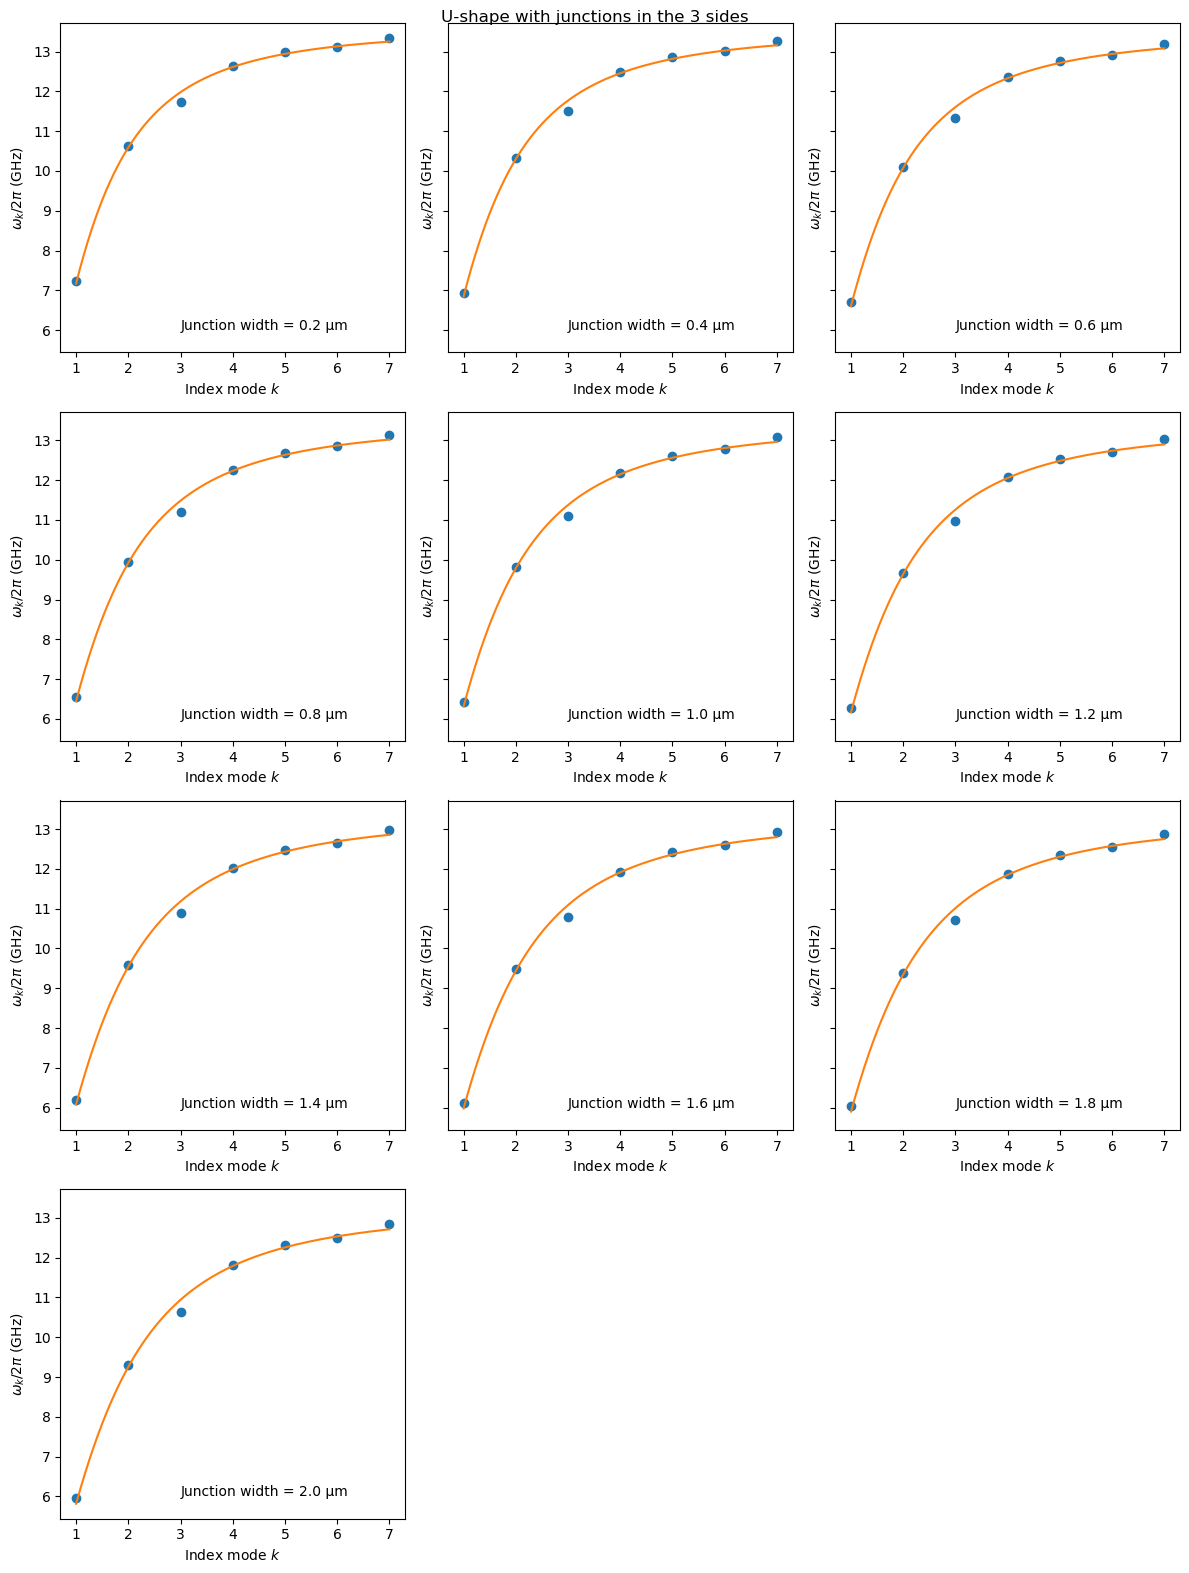

In [809]:
theoretical = 1/2/np.pi/np.sqrt(4.1e-9*32.4e-15)
# Calcular el número de filas necesario para 3 columnas
n_plots = len(resonances_array)
n_rows = int(np.ceil(n_plots / 3))

xdata_intrpl = np.linspace(np.min(xdata),np.max(xdata),1000)
fig, ax = plt.subplots(n_rows, 3, figsize=(12, 4*n_rows), sharey=True)
fig.suptitle('U-shape with junctions in the 3 sides')
for i in range(n_plots):
    row = i // 3
    col = i % 3
    
    ax[row, col].plot(xdata, resonances_array[i] * 1e-9, 'o')
    ax[row, col].plot(xdata_intrpl, resonance_model(xdata_intrpl, fp_fit[i], ratio_fit[i]) * 1e-9)
    ax[row, col].set_xlabel(r'Index mode $k$')
    ax[row, col].set_ylabel(r'$\omega_k/2\pi$ (GHz)')
    ax[row, col].text(x=3, y=6, s=f'Junction width = {data.iloc[i, 1]} µm')

# Para los subplots que no se usan, desactivarlos
for j in range(i+1, n_rows * 3):
    fig.delaxes(ax.flatten()[j])

plt.tight_layout()
plt.show()

U-shape with junctions in only 2 sides:

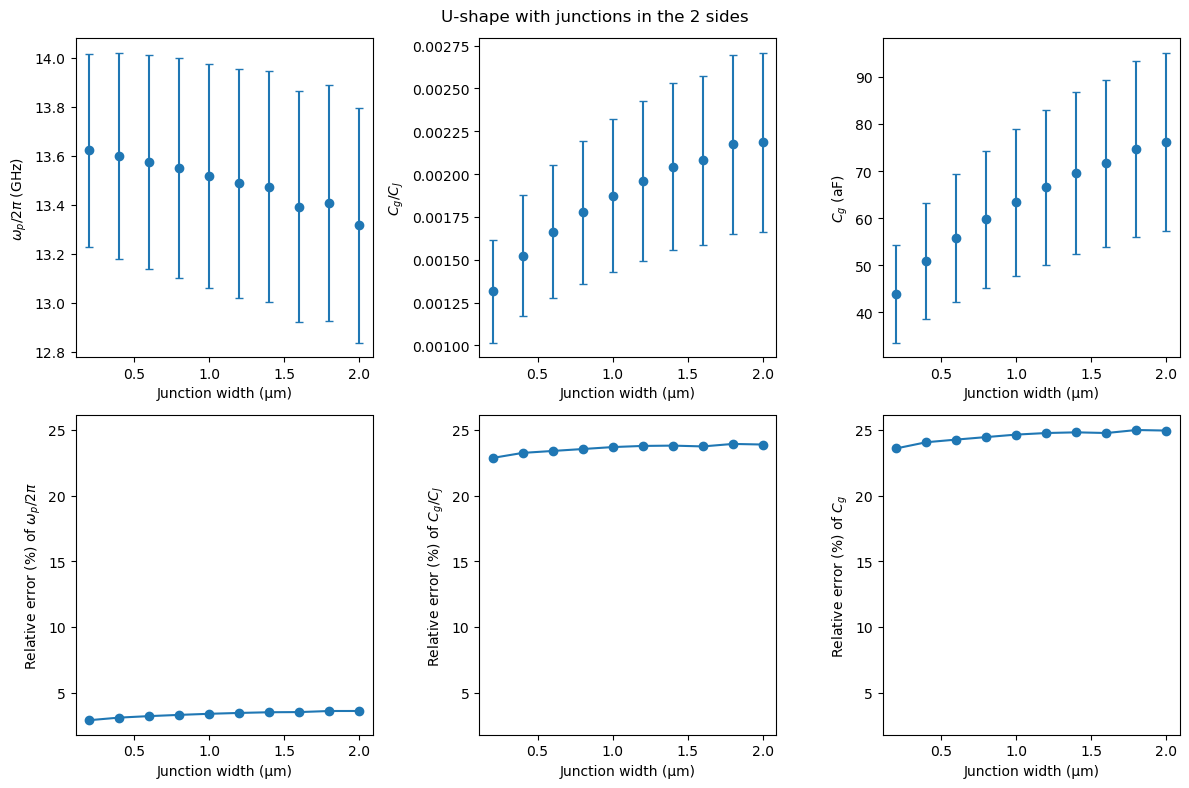

In [788]:
data = pd.read_csv('u_shape_widths_2.csv')
resonances_array = np.zeros((len(data),len(data.iloc[0,2:])))
fp_fit = np.zeros(len(data))
ratio_fit = np.zeros(len(data))
sd_fp = np.zeros(len(data))
sd_ratio = np.zeros(len(data))
xdata = np.arange(1,len(data.iloc[0,2:])+1)
parametros_iniciales = [13.3e9,0.0003]

widths = data.iloc[:,1]
for i,width in enumerate(widths):
    resonances_array[i] = data.iloc[i,2:]
    fit, covarianza = curve_fit(resonance_model, xdata, resonances_array[i], p0=parametros_iniciales)
    fp_fit[i], ratio_fit[i] = fit
    sd_fp[i] = np.sqrt(covarianza[0,0])
    sd_ratio[i] = np.sqrt(covarianza[1,1])

fig,ax = plt.subplots(2,3,figsize = (12,8))
fig.suptitle('U-shape with junctions in the 2 sides')
ax[0,0].errorbar(widths, fp_fit*1e-9, yerr=sd_fp*1e-9, fmt='o', capsize=3, capthick=1)
ax[0,1].errorbar(widths, ratio_fit, yerr=sd_ratio, fmt='o', capsize=3, capthick=1)
ax[0,0].set_xlabel(r'Junction width (µm)')
ax[0,1].set_xlabel(r'Junction width (µm)')
ax[0,0].set_ylabel(r'$\omega_p/2\pi$ (GHz)')
ax[0,1].set_ylabel(r'$C_g/C_J$')

ax[1, 1].sharey(ax[1, 0])
ax[1,0].plot(widths, sd_fp/fp_fit*100, 'o-')
ax[1,1].plot(widths, sd_ratio/ratio_fit*100,'o-')
ax[1,0].set_xlabel(r'Junction width (µm)')
ax[1,1].set_xlabel(r'Junction width (µm)')
ax[1,0].set_ylabel(r'Relative error (%) of $\omega_p/2\pi$')
ax[1,1].set_ylabel(r'Relative error (%) of $C_g/C_J$')
Cg = 1/4.1e-9*ratio_fit/(2*np.pi*fp_fit)**2
error_cg = Cg*np.sqrt((1 * sd_ratio/ratio_fit)**2 + (-2 * sd_fp/fp_fit)**2)
ax[0,2].errorbar(widths, Cg*1e18, yerr=error_cg*1e18, fmt='o', capsize=3, capthick=1)
ax[0,2].set_xlabel(r'Junction width (µm)')
ax[0,2].set_ylabel(r'$C_g$ (aF)')

ax[1, 2].sharey(ax[1, 0])
ax[1,2].plot(widths,error_cg/Cg*100, 'o-')
ax[1,2].set_xlabel(r'Junction width (µm)')
ax[1,2].set_ylabel(r'Relative error (%) of $C_g$')
plt.tight_layout()
plt.show()

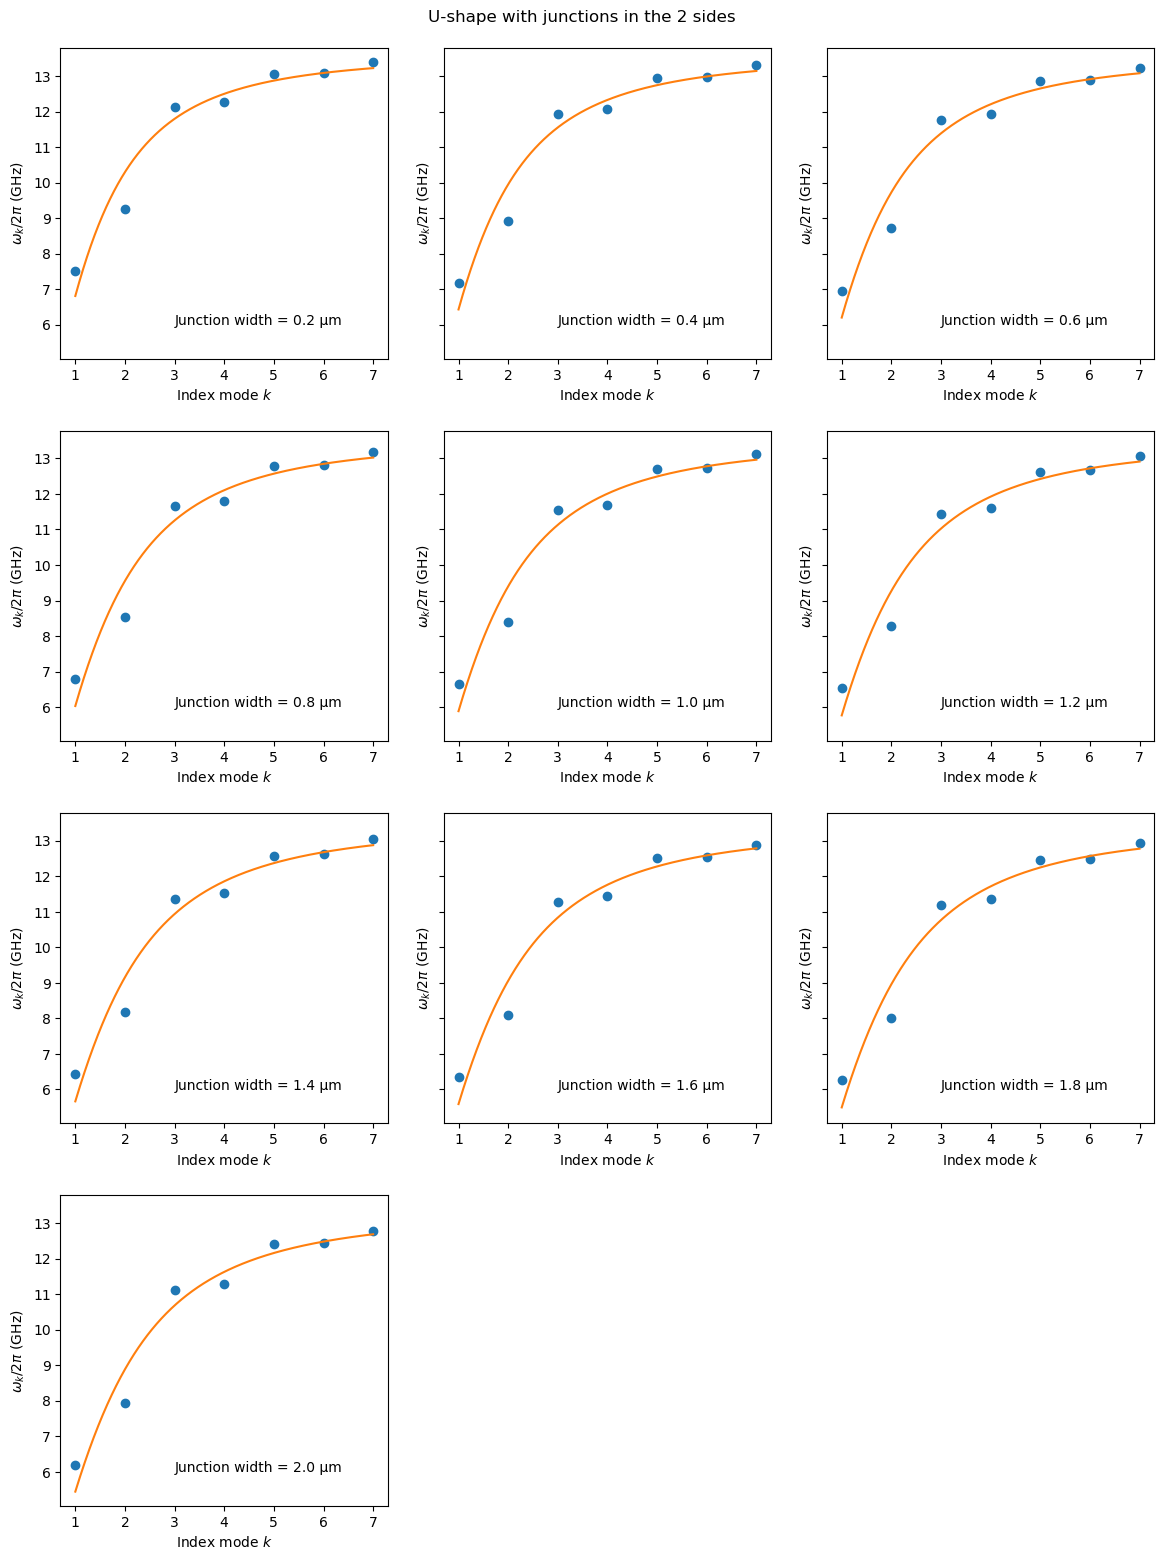

In [789]:
theoretical = 1/2/np.pi/np.sqrt(4.1e-9*32.4e-15)
# Calcular el número de filas necesario para 3 columnas
n_plots = len(resonances_array)
n_rows = int(np.ceil(n_plots / 3))

xdata_intrpl = np.linspace(np.min(xdata),np.max(xdata),1000)
fig, ax = plt.subplots(n_rows, 3, figsize=(12, 4*n_rows), sharey=True)
fig.suptitle('U-shape with junctions in the 2 sides')
for i in range(n_plots):
    row = i // 3
    col = i % 3
    
    ax[row, col].plot(xdata, resonances_array[i] * 1e-9, 'o')
    ax[row, col].plot(xdata_intrpl, resonance_model(xdata_intrpl, fp_fit[i], ratio_fit[i]) * 1e-9)
    ax[row, col].set_xlabel(r'Index mode $k$')
    ax[row, col].set_ylabel(r'$\omega_k/2\pi$ (GHz)')
    ax[row, col].text(x=3, y=6, s=f'Junction width = {data.iloc[i, 1]} µm')

# Para los subplots que no se usan, desactivarlos
for j in range(i+1, n_rows * 3):
    fig.delaxes(ax.flatten()[j])

plt.tight_layout(pad=2)
plt.show()

Changing the separation between the opposite sides but JJ in only two sides

In [739]:
data = pd.read_csv('u_shape_sep.csv')
data

,junction_width [um],side_separation [um],re(Mode(1)) [],re(Mode(2)) [],re(Mode(3)) [],re(Mode(4)) [],re(Mode(5)) [],re(Mode(6)) [],re(Mode(7)) []
0,2.5,5,5.188183e+09,9.169361e+09,1.048972e+10,1.166682e+10,1.210654e+10,1.249459e+10,1.265017e+10


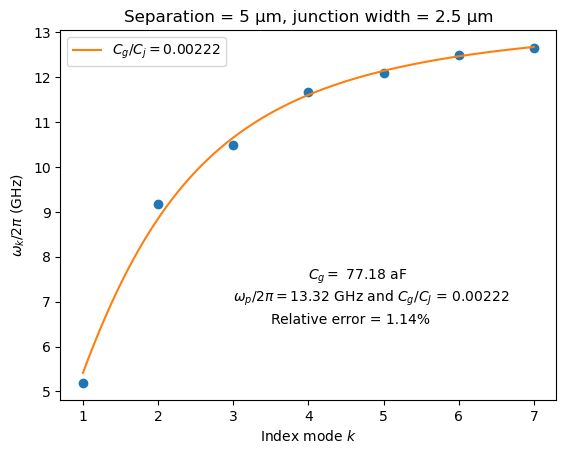

In [743]:
data = pd.read_csv('u_shape_sep.csv')
resonancias_experimentales = data.iloc[0,2:].values

# Ajuste de curva 
xdata = np.arange(1,len(resonancias_experimentales)+1)
parametros_iniciales = [13.8e9,0.0003]
# limites = ([0, 0, 0], [np.inf, np.inf, np.inf])
ajuste, covarianza = curve_fit(resonance_model, xdata, resonancias_experimentales, p0=parametros_iniciales)

# Los parámetros ajustados están en 'ajuste'
fp_fit,ratio_ajustado = ajuste
Cg_fit = ratio_ajustado/4.1e-9/(2*np.pi*fp_fit)**2

fig,ax = plt.subplots(1,1)
ax.plot(xdata,resonancias_experimentales*1e-9,'o')
x_data_2 = np.linspace(np.min(xdata),np.max(xdata),1000)
ax.plot(x_data_2,resonance_model(x_data_2, fp_fit,ratio_ajustado)*1e-9, label = rf'$C_g/C_j = {round(ratio_ajustado,5)}$')
ax.set_title(f'Separation = {data.iloc[0,1]} µm, junction width = {data.iloc[0,0]} µm')
ax.text(x=3.5, y = 6.5,s=f'Relative error = {round(np.sqrt(covarianza[0,0])/ajuste[0] *100,2)}%')
ax.text(x=3, y = 7,s=rf'$\omega_p/2\pi = {round(fp_fit*1e-9,2)}$ GHz and $C_g/C_J$ = {round(ratio_ajustado,5)}')
ax.text(x=4, y = 7.5,s=rf'$C_g =$ {round(Cg_fit*1e18,2)} aF')
ax.set_ylabel(r'$\omega_k/2\pi$ (GHz)')
ax.set_xlabel(r'Index mode $k$')
ax.legend()
plt.show()

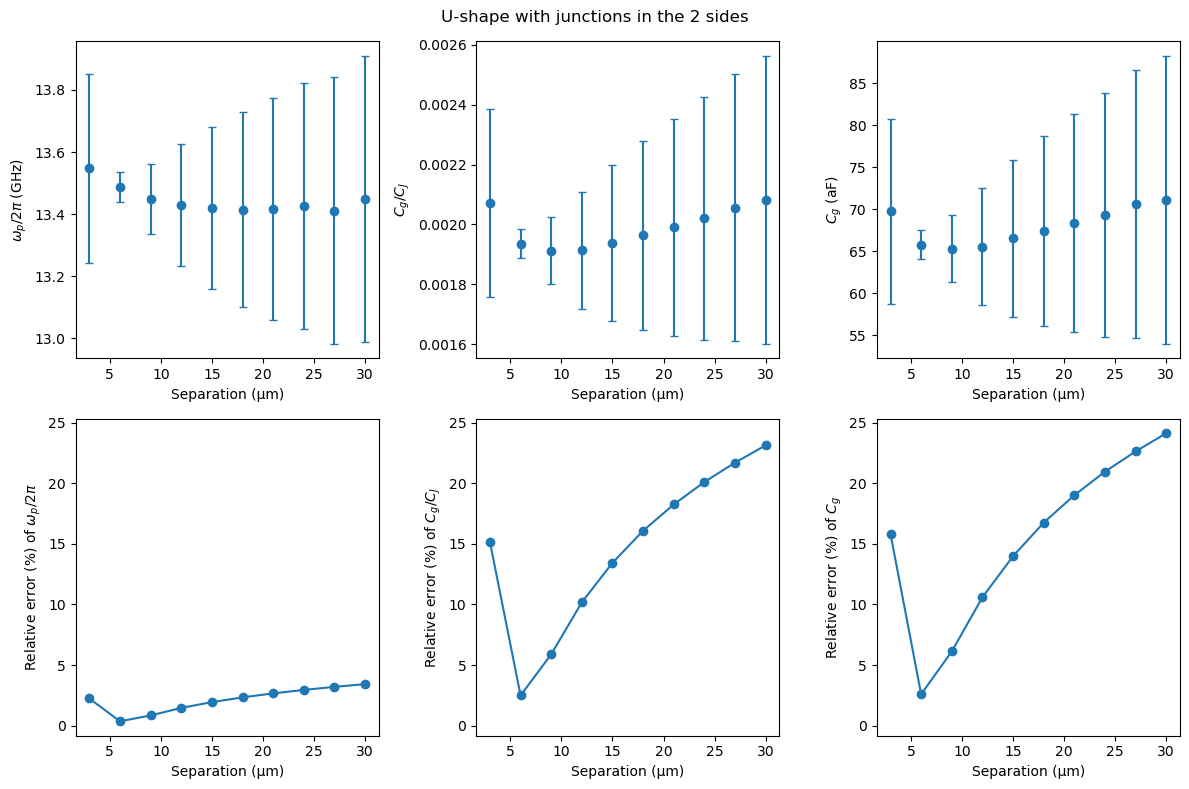

In [786]:
data = pd.read_csv('u_shape_sep_sweep.csv')
resonances_array = np.zeros((len(data),len(data.iloc[0,1:])))
fp_fit = np.zeros(len(data))
ratio_fit = np.zeros(len(data))
sd_fp = np.zeros(len(data))
sd_ratio = np.zeros(len(data))
xdata = np.arange(1,len(data.iloc[0,1:])+1)
parametros_iniciales = [13.3e9,0.0003]

seps = data.iloc[:,0]
for i,sep in enumerate(seps):
    resonances_array[i] = data.iloc[i,1:]
    fit, covarianza = curve_fit(resonance_model, xdata, resonances_array[i], p0=parametros_iniciales)
    fp_fit[i], ratio_fit[i] = fit
    sd_fp[i] = np.sqrt(covarianza[0,0])
    sd_ratio[i] = np.sqrt(covarianza[1,1])

fig,ax = plt.subplots(2,3,figsize = (12,8))
fig.suptitle('U-shape with junctions in the 2 sides')
ax[0,0].errorbar(seps, fp_fit*1e-9, yerr=sd_fp*1e-9, fmt='o', capsize=3, capthick=1)
ax[0,1].errorbar(seps, ratio_fit, yerr=sd_ratio, fmt='o', capsize=3, capthick=1)
ax[0,0].set_xlabel(r'Separation (µm)')
ax[0,1].set_xlabel(r'Separation (µm)')
ax[0,0].set_ylabel(r'$\omega_p/2\pi$ (GHz)')
ax[0,1].set_ylabel(r'$C_g/C_J$')

ax[1, 1].sharey(ax[1, 0])
ax[1,0].plot(seps, sd_fp/fp_fit*100, 'o-')
ax[1,1].plot(seps, sd_ratio/ratio_fit*100,'o-')
ax[1,0].set_xlabel(r'Separation (µm)')
ax[1,1].set_xlabel(r'Separation (µm)')
ax[1,0].set_ylabel(r'Relative error (%) of $\omega_p/2\pi$')
ax[1,1].set_ylabel(r'Relative error (%) of $C_g/C_J$')
Cg = 1/4.1e-9*ratio_fit/(2*np.pi*fp_fit)**2
error_cg = Cg*np.sqrt((1 * sd_ratio/ratio_fit)**2 + (-2 * sd_fp/fp_fit)**2)
ax[0,2].errorbar(seps, Cg*1e18, yerr=error_cg*1e18, fmt='o', capsize=3, capthick=1)
ax[0,2].set_xlabel(r'Separation (µm)')
ax[0,2].set_ylabel(r'$C_g$ (aF)')

ax[1, 2].sharey(ax[1, 0])
ax[1,2].plot(seps,error_cg/Cg*100, 'o-')
ax[1,2].set_xlabel(r'Separation (µm)')
ax[1,2].set_ylabel(r'Relative error (%) of $C_g$')
plt.tight_layout()
plt.show()

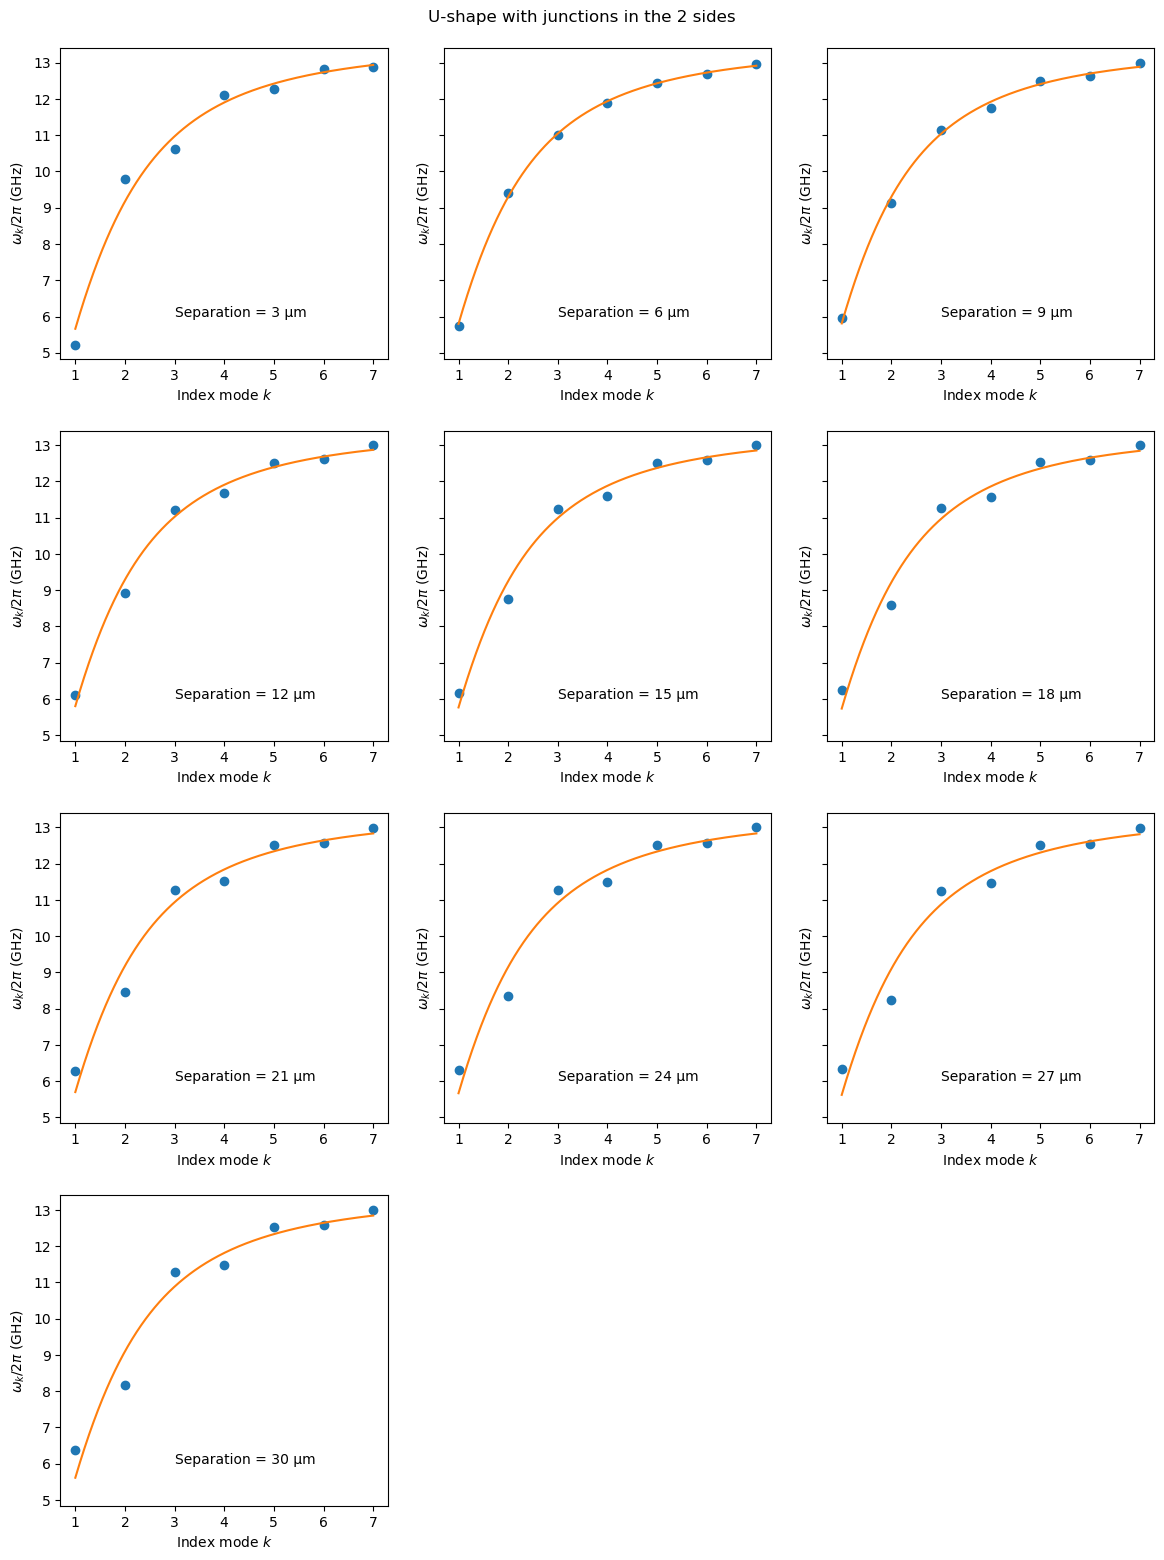

In [787]:
# Calcular el número de filas necesario para 3 columnas
n_plots = len(resonances_array)
n_rows = int(np.ceil(n_plots / 3))

xdata_intrpl = np.linspace(np.min(xdata),np.max(xdata),1000)
fig, ax = plt.subplots(n_rows, 3, figsize=(12, 4*n_rows), sharey=True)
fig.suptitle('U-shape with junctions in the 2 sides')
for i in range(n_plots):
    row = i // 3
    col = i % 3
    
    ax[row, col].plot(xdata, resonances_array[i] * 1e-9, 'o')
    ax[row, col].plot(xdata_intrpl, resonance_model(xdata_intrpl, fp_fit[i], ratio_fit[i]) * 1e-9)
    ax[row, col].set_xlabel(r'Index mode $k$')
    ax[row, col].set_ylabel(r'$\omega_k/2\pi$ (GHz)')
    ax[row, col].text(x=3, y=6, s=f'Separation = {data.iloc[i, 0]} µm')

# Para los subplots que no se usan, desactivarlos
for j in range(i+1, n_rows * 3):
    fig.delaxes(ax.flatten()[j])

plt.tight_layout(pad=2)
plt.show()

.1 The same but with more points

In [803]:
#Showing that one row doesn't converge
convergence = pd.read_csv('u_shape_sep_sweep_fined_convergence.csv')
convergence

,side_separation [um],MaxDeltaFreq []
0,1.500000,0.093635
1,2.736842,0.073598
2,3.973684,0.061983
3,5.210526,0.082400
4,6.447368,0.097526
5,7.684211,0.083241
6,8.921053,0.065537
7,10.157895,0.083026
8,11.394737,0.095593
9,12.631579,0.092032


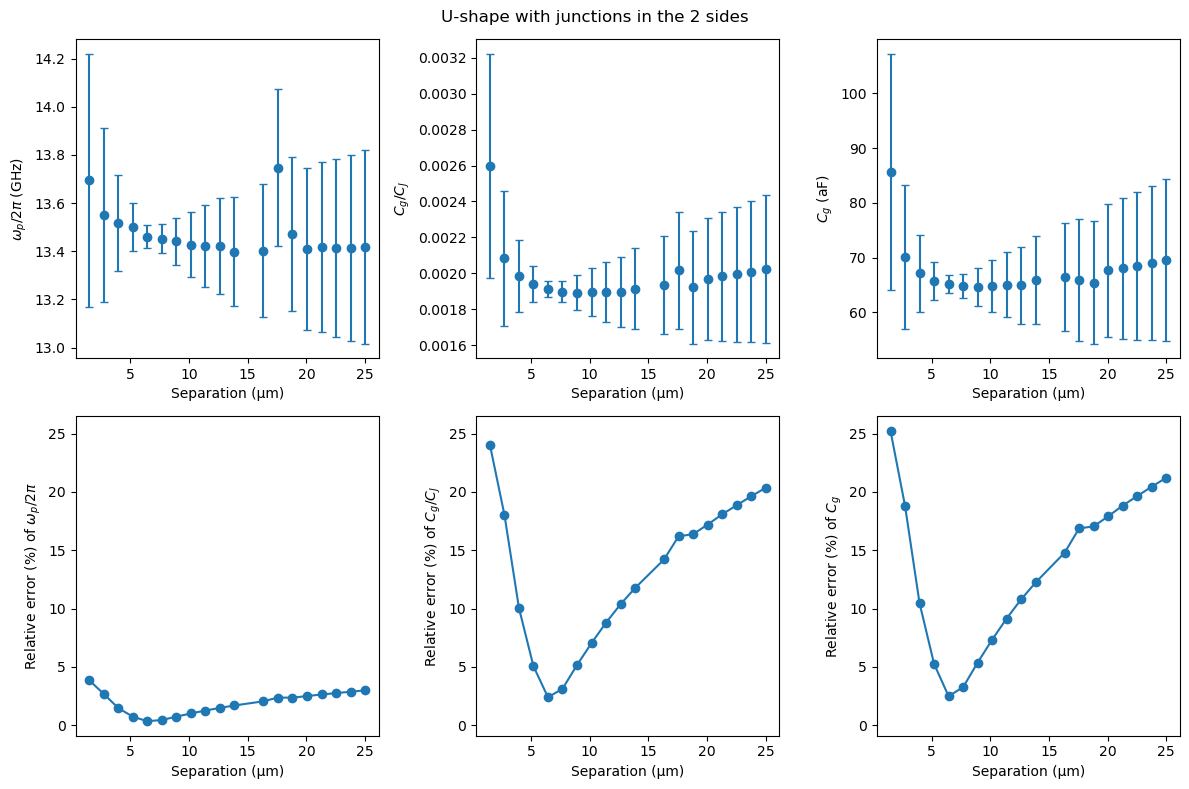

In [806]:
data = pd.read_csv('u_shape_sep_sweep_fined.csv')
data = data.drop(11)

resonances_array = np.zeros((len(data),len(data.iloc[0,1:])))
fp_fit = np.zeros(len(data))
ratio_fit = np.zeros(len(data))
sd_fp = np.zeros(len(data))
sd_ratio = np.zeros(len(data))
xdata = np.arange(1,len(data.iloc[0,1:])+1)
parametros_iniciales = [13.3e9,0.0003]

seps = data.iloc[:,0]
for i,sep in enumerate(seps):
    resonances_array[i] = data.iloc[i,1:]
    fit, covarianza = curve_fit(resonance_model, xdata, resonances_array[i], p0=parametros_iniciales)
    fp_fit[i], ratio_fit[i] = fit
    sd_fp[i] = np.sqrt(covarianza[0,0])
    sd_ratio[i] = np.sqrt(covarianza[1,1])

fig,ax = plt.subplots(2,3,figsize = (12,8))
fig.suptitle('U-shape with junctions in the 2 sides')
ax[0,0].errorbar(seps, fp_fit*1e-9, yerr=sd_fp*1e-9, fmt='o', capsize=3, capthick=1)
ax[0,1].errorbar(seps, ratio_fit, yerr=sd_ratio, fmt='o', capsize=3, capthick=1)
ax[0,0].set_xlabel(r'Separation (µm)')
ax[0,1].set_xlabel(r'Separation (µm)')
ax[0,0].set_ylabel(r'$\omega_p/2\pi$ (GHz)')
ax[0,1].set_ylabel(r'$C_g/C_J$')

ax[1, 1].sharey(ax[1, 0])
ax[1,0].plot(seps, sd_fp/fp_fit*100, 'o-')
ax[1,1].plot(seps, sd_ratio/ratio_fit*100,'o-')
ax[1,0].set_xlabel(r'Separation (µm)')
ax[1,1].set_xlabel(r'Separation (µm)')
ax[1,0].set_ylabel(r'Relative error (%) of $\omega_p/2\pi$')
ax[1,1].set_ylabel(r'Relative error (%) of $C_g/C_J$')

Cg = 1/4.1e-9*ratio_fit/(2*np.pi*fp_fit)**2
error_cg = Cg*np.sqrt((1 * sd_ratio/ratio_fit)**2 + (-2 * sd_fp/fp_fit)**2)
ax[0,2].errorbar(seps, Cg*1e18, yerr=error_cg*1e18, fmt='o', capsize=3, capthick=1)
ax[0,2].set_xlabel(r'Separation (µm)')
ax[0,2].set_ylabel(r'$C_g$ (aF)')
ax[1, 2].sharey(ax[1, 0])
ax[1,2].plot(seps,error_cg/Cg*100, 'o-')
ax[1,2].set_xlabel(r'Separation (µm)')
ax[1,2].set_ylabel(r'Relative error (%) of $C_g$')
plt.tight_layout()
plt.show()

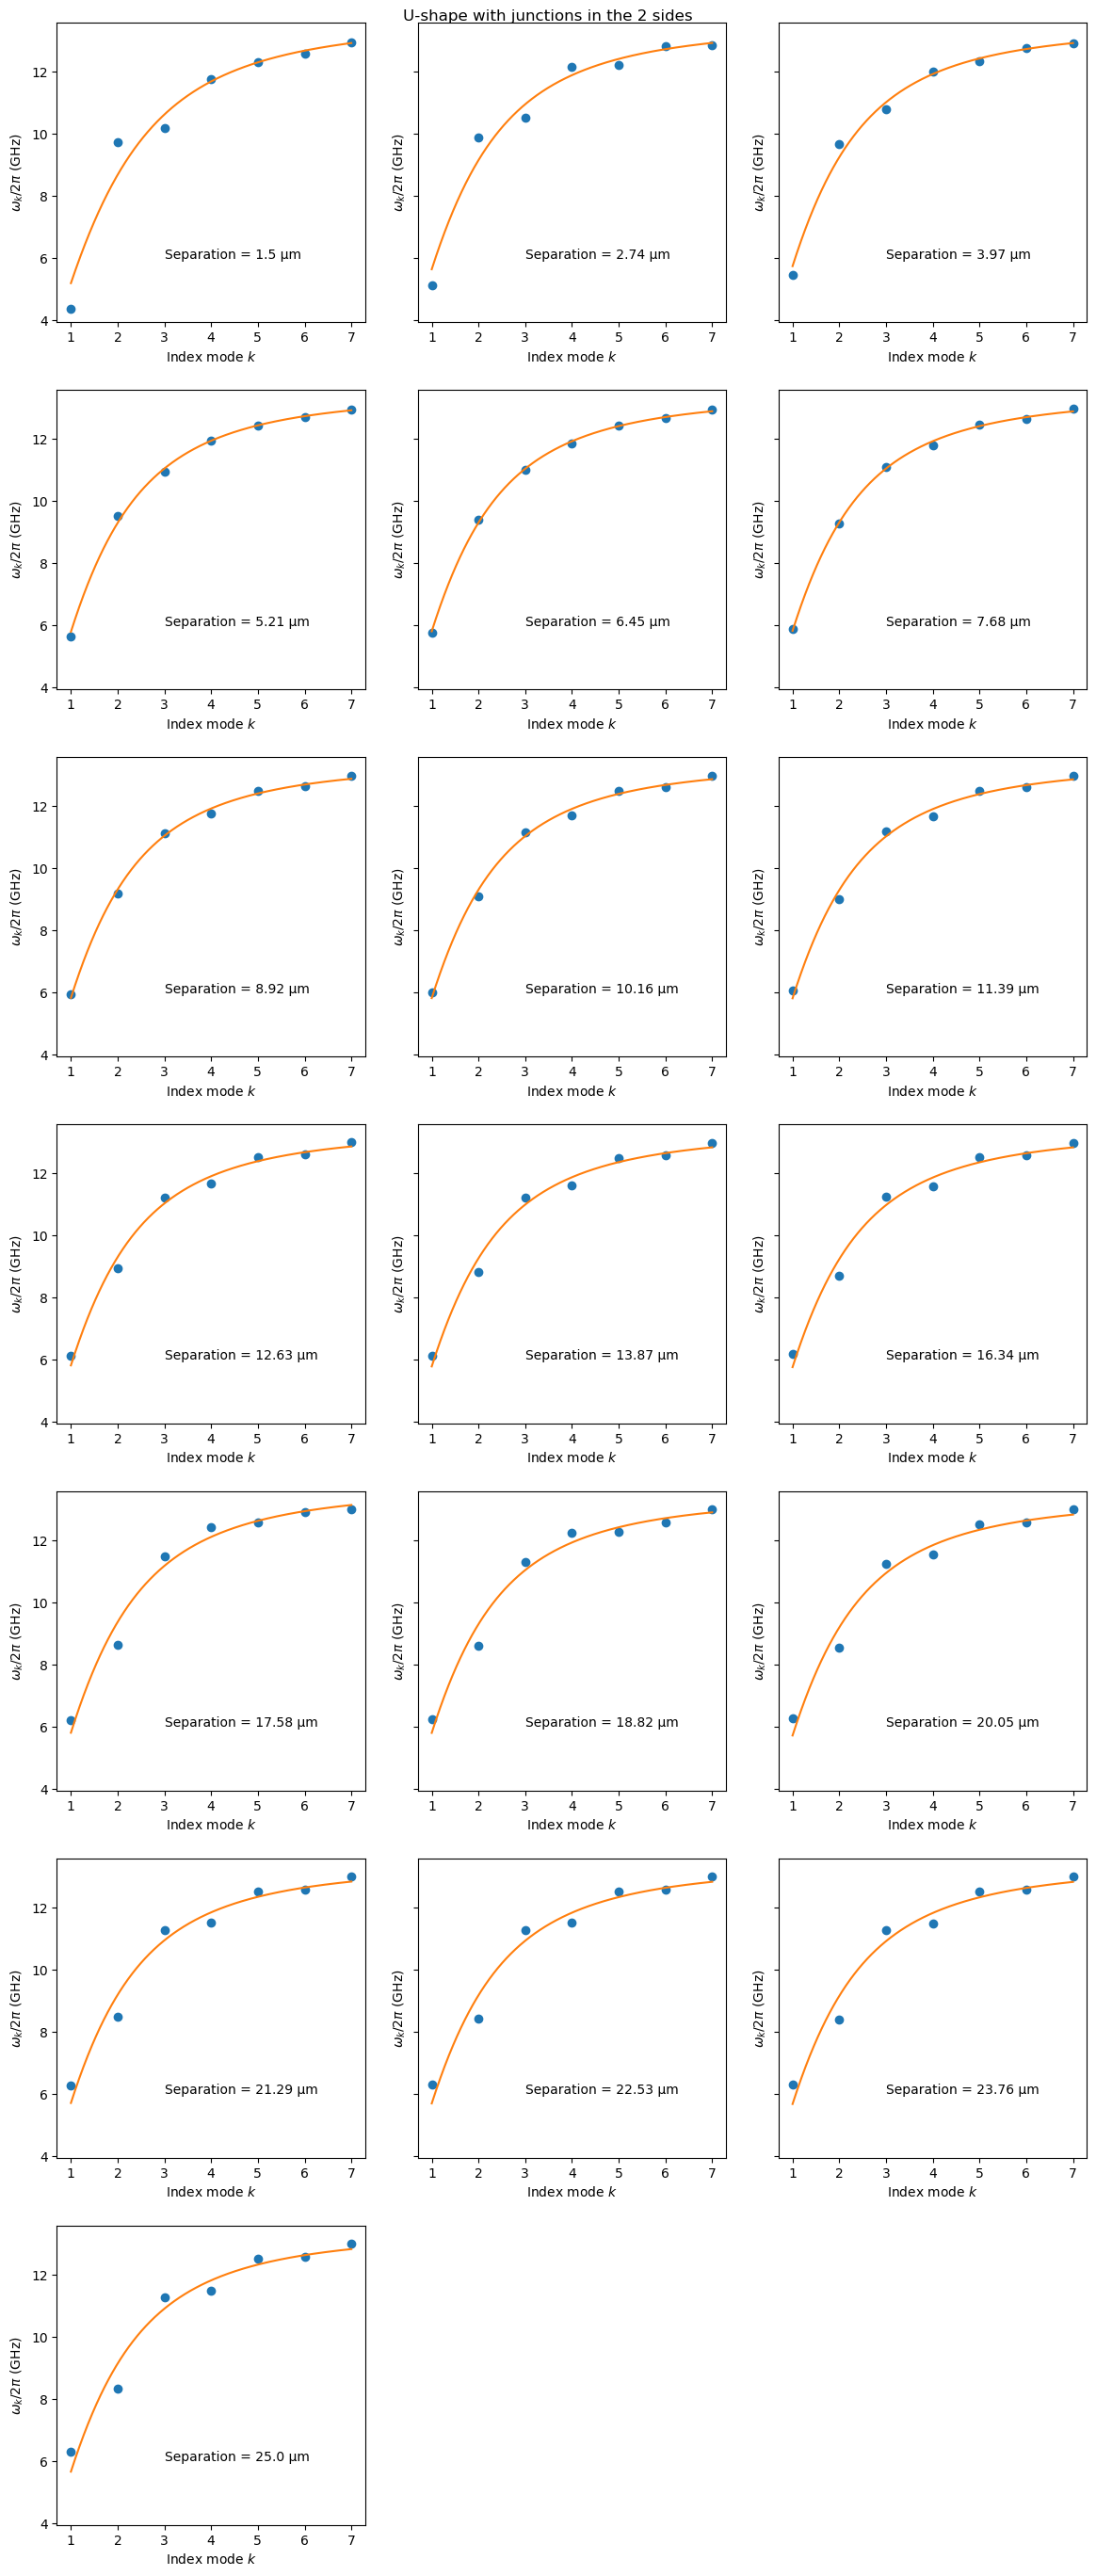

In [807]:
# Calcular el número de filas necesario para 3 columnas
n_plots = len(resonances_array)
n_rows = int(np.ceil(n_plots / 3))

xdata_intrpl = np.linspace(np.min(xdata),np.max(xdata),1000)
fig, ax = plt.subplots(n_rows, 3, figsize=(12, 4*n_rows), sharey=True)
fig.suptitle('U-shape with junctions in the 2 sides')
for i in range(n_plots):
    row = i // 3
    col = i % 3
    
    ax[row, col].plot(xdata, resonances_array[i] * 1e-9, 'o')
    ax[row, col].plot(xdata_intrpl, resonance_model(xdata_intrpl, fp_fit[i], ratio_fit[i]) * 1e-9)
    ax[row, col].set_xlabel(r'Index mode $k$')
    ax[row, col].set_ylabel(r'$\omega_k/2\pi$ (GHz)')
    ax[row, col].text(x=3, y=6, s=f'Separation = {round(data.iloc[i, 0],2)} µm')

# Para los subplots que no se usan, desactivarlos
for j in range(i+1, n_rows * 3):
    fig.delaxes(ax.flatten()[j])

plt.tight_layout(pad=2.0)
plt.show()

Now I will do the same for a geometry in which I have the two parts of the meander

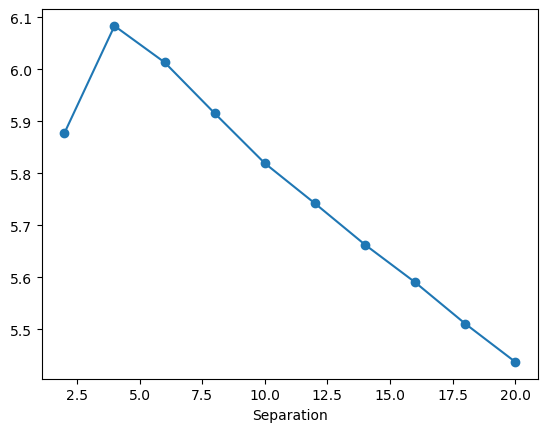

In [842]:
fig,ax = plt.subplots(1,1)
ax.plot(data.iloc[:,0], data.iloc[:,1]*1e-9, 'o-')
ax.set_xlabel('Separation')
plt.show()

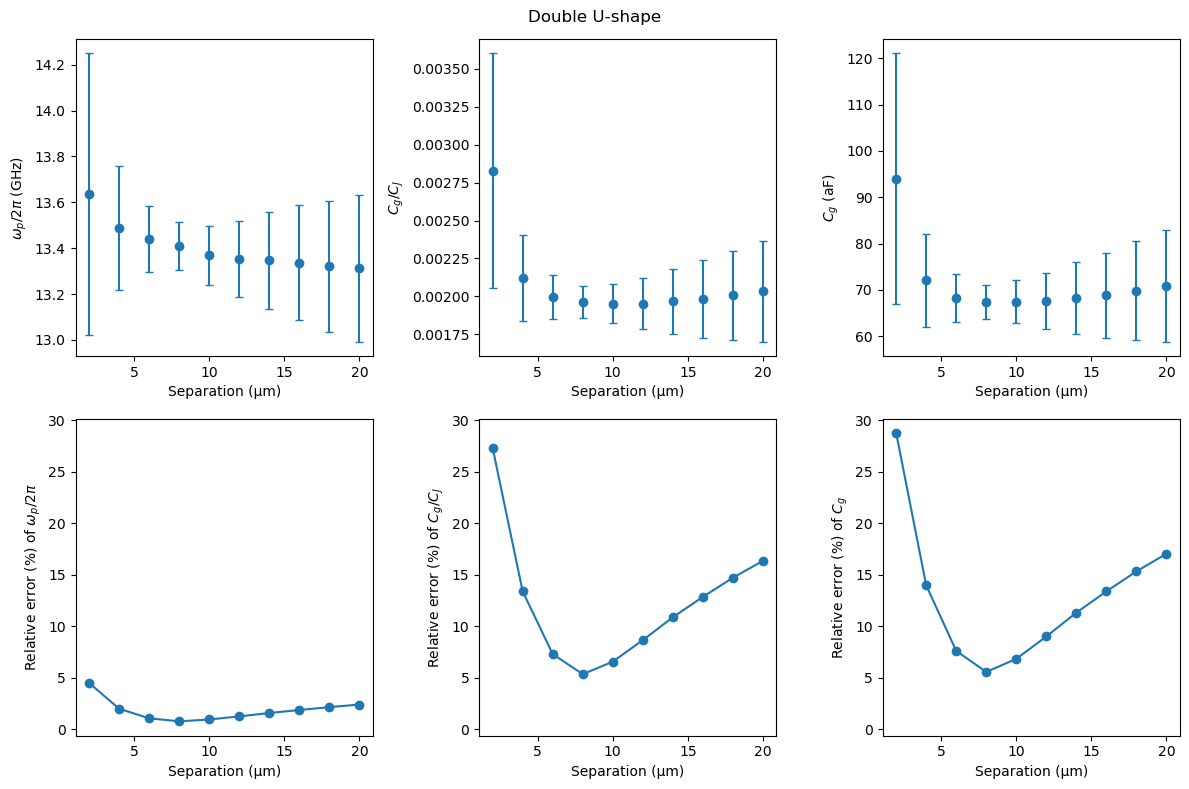

In [830]:
data = pd.read_csv('double_u_shape_sep_sweep.csv')

resonances_array = np.zeros((len(data),len(data.iloc[0,1:])))
fp_fit = np.zeros(len(data))
ratio_fit = np.zeros(len(data))
sd_fp = np.zeros(len(data))
sd_ratio = np.zeros(len(data))
xdata = np.arange(1,len(data.iloc[0,1:])+1)
parametros_iniciales = [13.3e9,0.0003]

seps = data.iloc[:,0]
for i,sep in enumerate(seps):
    resonances_array[i] = data.iloc[i,1:]
    fit, covarianza = curve_fit(resonance_model, xdata, resonances_array[i], p0=parametros_iniciales)
    fp_fit[i], ratio_fit[i] = fit
    sd_fp[i] = np.sqrt(covarianza[0,0])
    sd_ratio[i] = np.sqrt(covarianza[1,1])

fig,ax = plt.subplots(2,3,figsize = (12,8))
fig.suptitle('Double U-shape')
ax[0,0].errorbar(seps, fp_fit*1e-9, yerr=sd_fp*1e-9, fmt='o', capsize=3, capthick=1)
ax[0,1].errorbar(seps, ratio_fit, yerr=sd_ratio, fmt='o', capsize=3, capthick=1)
ax[0,0].set_xlabel(r'Separation (µm)')
ax[0,1].set_xlabel(r'Separation (µm)')
ax[0,0].set_ylabel(r'$\omega_p/2\pi$ (GHz)')
ax[0,1].set_ylabel(r'$C_g/C_J$')

ax[1, 1].sharey(ax[1, 0])
ax[1,0].plot(seps, sd_fp/fp_fit*100, 'o-')
ax[1,1].plot(seps, sd_ratio/ratio_fit*100,'o-')
ax[1,0].set_xlabel(r'Separation (µm)')
ax[1,1].set_xlabel(r'Separation (µm)')
ax[1,0].set_ylabel(r'Relative error (%) of $\omega_p/2\pi$')
ax[1,1].set_ylabel(r'Relative error (%) of $C_g/C_J$')

Cg = 1/4.1e-9*ratio_fit/(2*np.pi*fp_fit)**2
error_cg = Cg*np.sqrt((1 * sd_ratio/ratio_fit)**2 + (-2 * sd_fp/fp_fit)**2)
ax[0,2].errorbar(seps, Cg*1e18, yerr=error_cg*1e18, fmt='o', capsize=3, capthick=1)
ax[0,2].set_xlabel(r'Separation (µm)')
ax[0,2].set_ylabel(r'$C_g$ (aF)')
ax[1, 2].sharey(ax[1, 0])
ax[1,2].plot(seps,error_cg/Cg*100, 'o-')
ax[1,2].set_xlabel(r'Separation (µm)')
ax[1,2].set_ylabel(r'Relative error (%) of $C_g$')
plt.tight_layout()
plt.show()

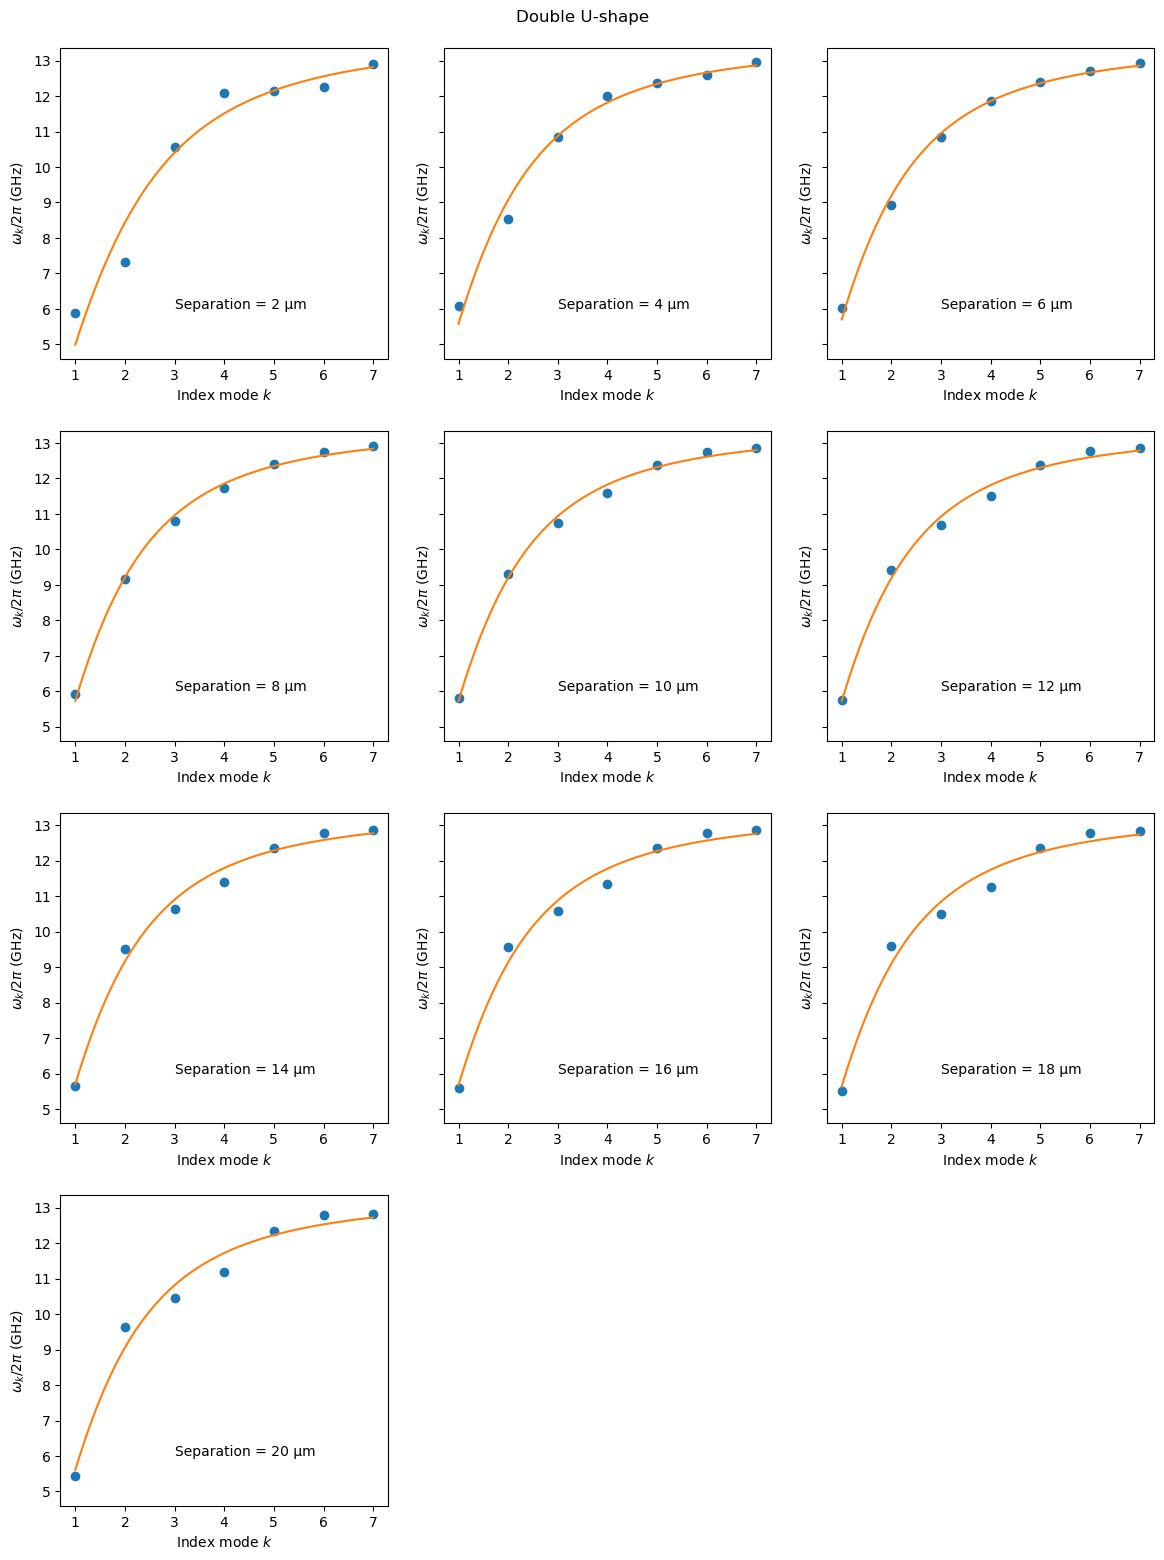

In [831]:
# Calcular el número de filas necesario para 3 columnas
n_plots = len(resonances_array)
n_rows = int(np.ceil(n_plots / 3))

xdata_intrpl = np.linspace(np.min(xdata),np.max(xdata),1000)
fig, ax = plt.subplots(n_rows, 3, figsize=(12, 4*n_rows), sharey=True)
fig.suptitle('Double U-shape')
for i in range(n_plots):
    row = i // 3
    col = i % 3
    
    ax[row, col].plot(xdata, resonances_array[i] * 1e-9, 'o')
    ax[row, col].plot(xdata_intrpl, resonance_model(xdata_intrpl, fp_fit[i], ratio_fit[i]) * 1e-9)
    ax[row, col].set_xlabel(r'Index mode $k$')
    ax[row, col].set_ylabel(r'$\omega_k/2\pi$ (GHz)')
    ax[row, col].text(x=3, y=6, s=f'Separation = {round(data.iloc[i, 0],2)} µm')

# Para los subplots que no se usan, desactivarlos
for j in range(i+1, n_rows * 3):
    fig.delaxes(ax.flatten()[j])

plt.tight_layout(pad=2.0)
plt.show()

Analyzing the U-shape with JJ in the opposite 2 sides with a model when we have a Cg bigger in the connector between the JJAs

In [961]:
from tqdm.notebook import tqdm
data = pd.read_csv('u_shape_sep_sweep.csv')
separation_array = data.iloc[:,0]
optimal_params_list = []

param_ranges = [(1e-15, 100e-15), # Range for Cjj
                (1e-20, 1e-15), # Range for Cg 
                (1e-20, 100e-15)] # Range for Cg big

for i,sep in enumerate(tqdm(separation_array)):
    resonancias_experimentales = data.iloc[i,1:]
    def objective_function(params):
        model_vals = frequency_array_fit4(params)
        return np.sum((model_vals - resonancias_experimentales)**2)
    
    results = differential_evolution(objective_function, param_ranges)
    optimal_params_list.append(results.x)

  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\jc269556\Documents\Fermionic-bosonic-qubit\jj.py:137: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals)/2/np.pi


In [977]:
optimal_params_list

[array([3.36422329e-14, 7.11666611e-17, 1.48018107e-19]),
 array([3.39799129e-14, 6.70264379e-17, 1.90206791e-19]),
 array([3.40868662e-14, 6.21263330e-17, 8.14402182e-16]),
 array([3.41956121e-14, 5.90200381e-17, 1.45823279e-15]),
 array([3.43111904e-14, 5.74166446e-17, 2.01215920e-15]),
 array([3.44041605e-14, 5.61398710e-17, 2.53051379e-15]),
 array([3.44628577e-14, 5.53116938e-17, 3.00080096e-15]),
 array([3.45117389e-14, 5.46151557e-17, 3.48099999e-15]),
 array([3.46600412e-14, 5.44432497e-17, 3.95440852e-15]),
 array([3.45311092e-14, 5.37499126e-17, 4.38609225e-15])]

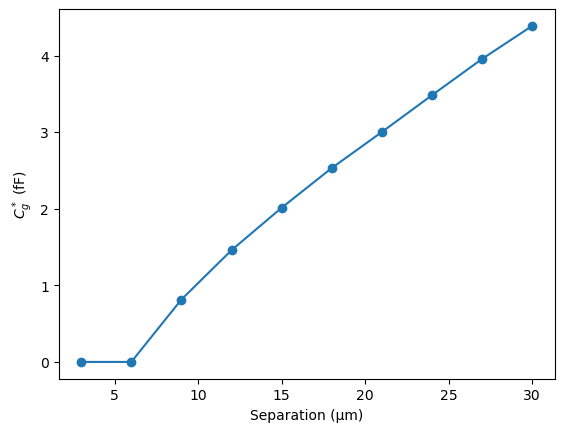

In [975]:
fig,ax = plt.subplots(1,1)
optimal_params_array = np.array(optimal_params_list)
ax.plot(separation_array, optimal_params_array[:,2]*1e15,'o-')
ax.set_xlabel('Separation (µm)')
ax.set_ylabel(r'$C_g^*$ (fF)')
plt.show()

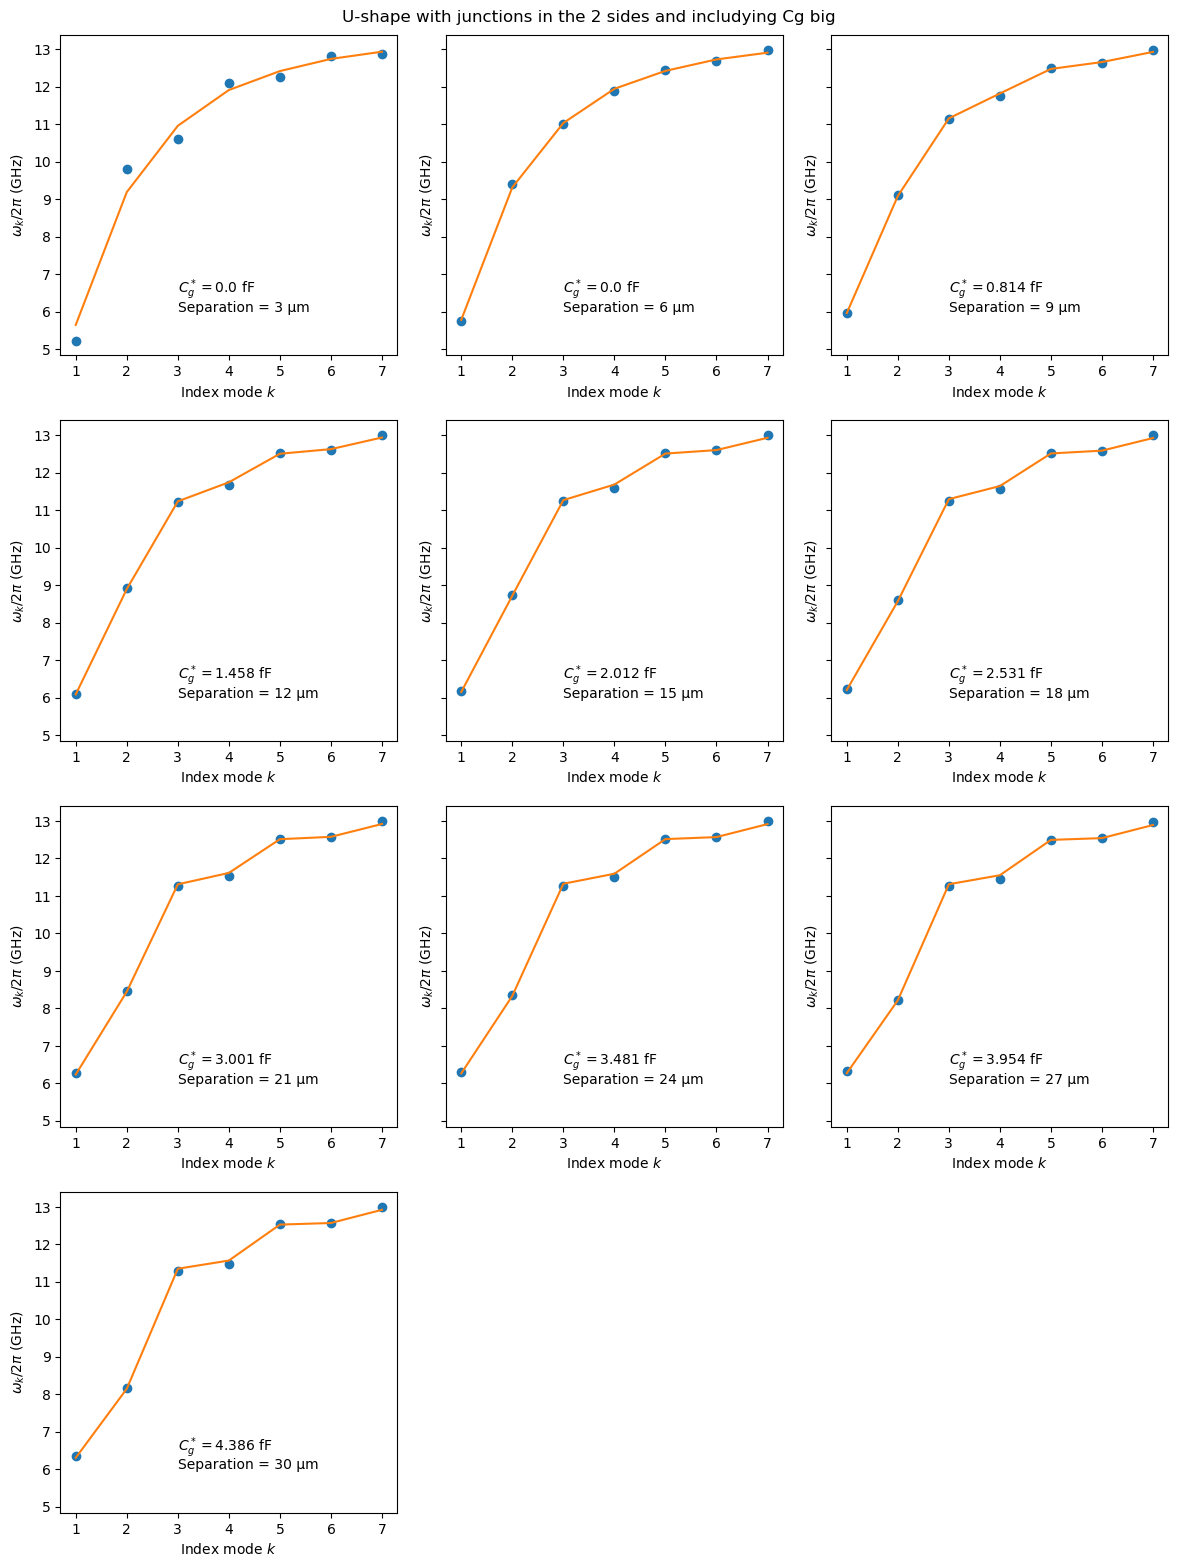

In [978]:
# Calcular el número de filas necesario para 3 columnas
n_plots = len(separation_array)
n_rows = int(np.ceil(n_plots / 3))

fig, ax = plt.subplots(n_rows, 3, figsize=(12, 4*n_rows), sharey=True)
fig.suptitle('U-shape with junctions in the 2 sides and includying Cg big')
for i in range(n_plots):
    row = i // 3
    col = i % 3
    
    ax[row, col].plot(xdata, data.iloc[i,1:] * 1e-9, 'o')
    ax[row, col].plot(xdata, frequency_array_fit4(optimal_params_list[i])*1e-9)
    ax[row, col].set_xlabel(r'Index mode $k$')
    ax[row, col].set_ylabel(r'$\omega_k/2\pi$ (GHz)')
    ax[row, col].text(x=3, y=6, s=f'Separation = {data.iloc[i, 0]} µm')
    ax[row, col].text(x=3, y=6.5, s=f'$C_g^* = {round(optimal_params_list[i][2]*1e15,3)}$ fF')

# Para los subplots que no se usan, desactivarlos
for j in range(i+1, n_rows * 3):
    fig.delaxes(ax.flatten()[j])

plt.tight_layout(pad=1.5)
plt.show()

Doing the same as above but with the double U geometry